# Project Info
| Items | Description |
|----------|----------|
| Project Name   | Credit Card Transactions Fraud Detection |
| Project Resource   | Kaggle Page: https://www.kaggle.com/datasets/kartik2112/fraud-detection   |
| Google Drive Link |Project Location: https://drive.google.com/drive/folders/1VmnPMJu9nDSzxPllew2BVqN7sbTX7vzZ?usp=drive_link|
| Project Deliverable 01 (Due 10/10)|Case Background and Context, Dataset Description, Proposed ML Techniques |
| Project Deliverable 02 (Due 11/07)| EDA |
| Project Deliverable 03 (Due 12/05)| Jupyter Notebook, 3-page Report|

# **0.- Load Library**

In [ ]:
!pip install shap
!pip install scikeras[tensorflow]
!pip install lightgbm

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from IPython.display import Image

import sklearn
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
import shap

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline


#import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC, Precision, Recall

#import scikeras
#from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# **1.- Importing the dataset**

In [ ]:
drive.mount('/content/drive', force_remount = True)
df = pd.read_csv('/content/drive/My Drive/AML Project/fraudTrain.csv')
df = df.drop('Unnamed: 0', axis = 1)

Mounted at /content/drive


# **2.- Initial Data Exploration**

## **2.1.- Dataset overview**

First, let's see the shape of the dataset.

In [ ]:
print(f"The train dataset consists of {df.shape[0]:,} transactions, and there are {df.shape[1]} columns.")

The train dataset consists of 1,296,675 transactions, and there are 22 columns.


In [ ]:
print(f"The numeric features are:{df.select_dtypes(include=['number']).columns.tolist()}")
print(f"The categorical and date features are:{df.select_dtypes(exclude=['number']).columns.tolist()}")

The numeric features are:['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']
The categorical and date features are:['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']


In [ ]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city

The target variable is **is_fraud**, which is a binary variable that describes whether a transaction is fraudulent. Credit card fraud is the use of credit cards without the owner's permission to make a purchase or gain access to funds, and involves crime. The objective of this project is to use customer data provided to construct predictive models for fraud detection.

## **2.2.- Describing Fraud (label)**

Let's see how balanced the dataset is:

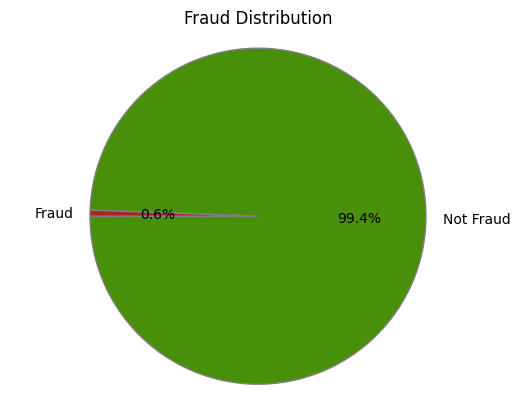

In [ ]:
fig, ax = plt.subplots()
ax.pie(df['is_fraud'].value_counts(), labels = df['is_fraud'].value_counts().index.map({1: 'Fraud', 0: 'Not Fraud'}), autopct = '%1.1f%%', startangle = 180, colors = ['#489009','#AC2424'], wedgeprops=dict(edgecolor='grey'))
ax.axis('equal')
ax.set_title('Fraud Distribution')
plt.show()

According to the pie chart above, the dataset is highly imbalanced: only 0.6% of the transactions corresponded to fraud. It is normal for such datasets to be highly imbalanced since fraudulent activities are relatively rare compared to legitimate transactions.

Let's also try to understand the distribution of fraud cases across these categorical variables: **category**, **gender**.

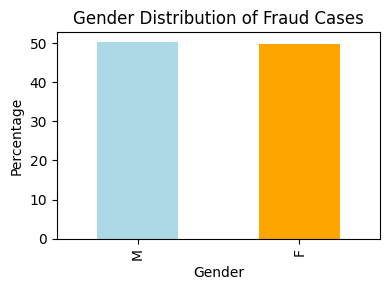

In [ ]:
# Filter out only fraud cases
fraud_df = df[df['is_fraud'] == 1]
gender_distribution = fraud_df['gender'].value_counts(normalize=True) * 100

#Plotting
plt.figure(figsize=(4, 3))
gender_distribution.plot(kind='bar', color=['lightblue', 'orange'])
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Gender Distribution of Fraud Cases')

plt.tight_layout()
plt.show()

We can see that the dataset indicates a balanced occurrence of fraud cases across genders, so there's no gender bias.


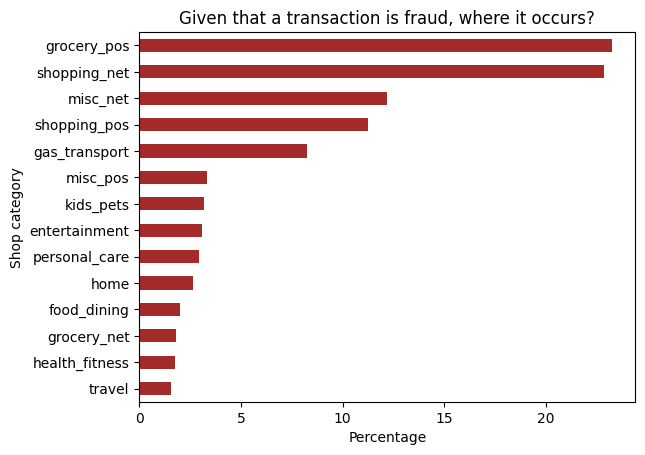

In [ ]:
#Distribution of fraud by category of shop - This chart shows the distribution across category shop for actual fraud transactions
category_distribution = fraud_df['category'].value_counts(normalize=True).sort_values(ascending = True) * 100
category_distribution.plot(kind='barh', color='brown')
plt.xlabel('Percentage')
plt.ylabel('Shop category')
plt.title('Given that a transaction is fraud, where it occurs?')
plt.show()

Fraudulent activities seem to be more common with two transaction types: pos transactions at grocery stores and online shopping.

Let's see if we notice some differences in amount for fraud non-fraud.

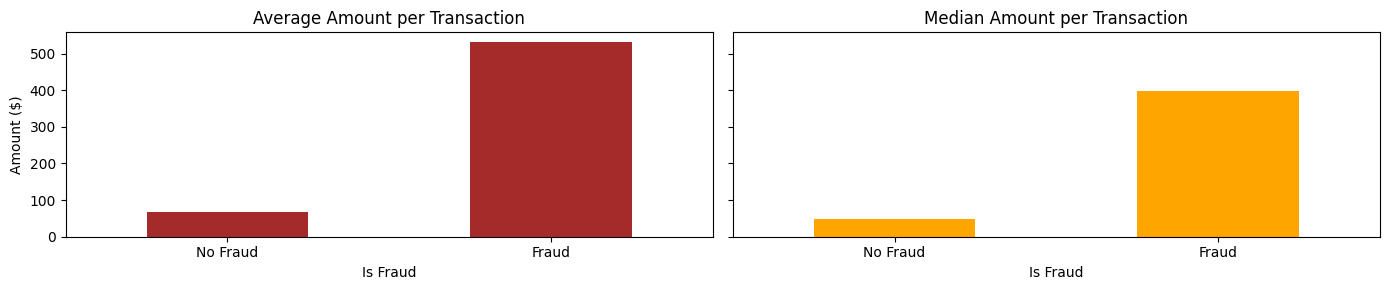

In [ ]:
fraud_stats = df.groupby('is_fraud')['amt'].agg(['mean', 'median']).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(14, 3), sharey = True)

# Bar chart for average amount by fraud status
fraud_stats.plot(kind='bar', x='is_fraud', y='mean', ax=axes[0], legend=False, color='brown')
axes[0].set_title('Average Amount per Transaction')
axes[0].set_xlabel('Is Fraud')
axes[0].set_ylabel('Amount ($)')
axes[0].set_xticklabels(['No Fraud', 'Fraud'], rotation=0)

# Bar chart for median amount by fraud status
fraud_stats.plot(kind='bar', x='is_fraud', y='median', ax=axes[1], legend=False, color='orange')
axes[1].set_title('Median Amount per Transaction')
axes[1].set_xlabel('Is Fraud')
axes[1].set_xticklabels(['No Fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

This tells us that amount should be a good explanatory variable for detecting fraud.

##**2.3.- Other visualizations to explore**

We can visualize whether the state play a rol in terms of occurrences:

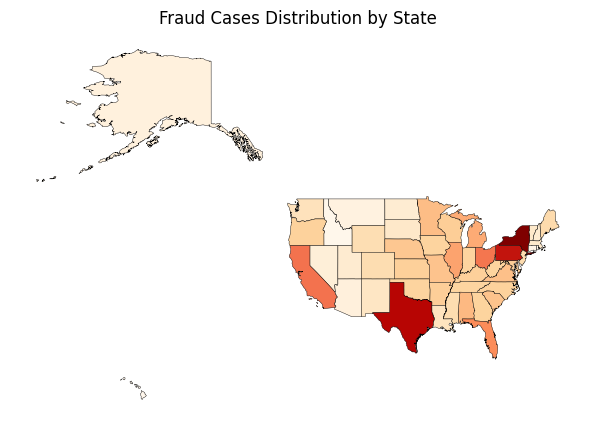

In [ ]:
#This file is from the US Census, and contains information about the states of US, so we can merge the datasets.
fraud_by_state = df.groupby('state')['is_fraud'].sum().reset_index()
us_states = gpd.read_file('zip:///content/drive/My Drive/AML Project/states_21basic.zip')
merged = us_states.set_index('STATE_ABBR').join(fraud_by_state.set_index('state'))

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
merged.plot(column='is_fraud', ax=ax, cmap='OrRd', missing_kwds={"color": "lightgrey"}, edgecolor = 'black', linewidth = 0.3)
ax.axis('off')
ax.set_title('Fraud Cases Distribution by State')
plt.show()

The majority of fraud cases occurred in Texas, California, New York, Pennsylvania, and Ohio. Additionally, it is observed that all states are represented in the dataset as no state is colored grey, indicating a nationwide scope in the data.

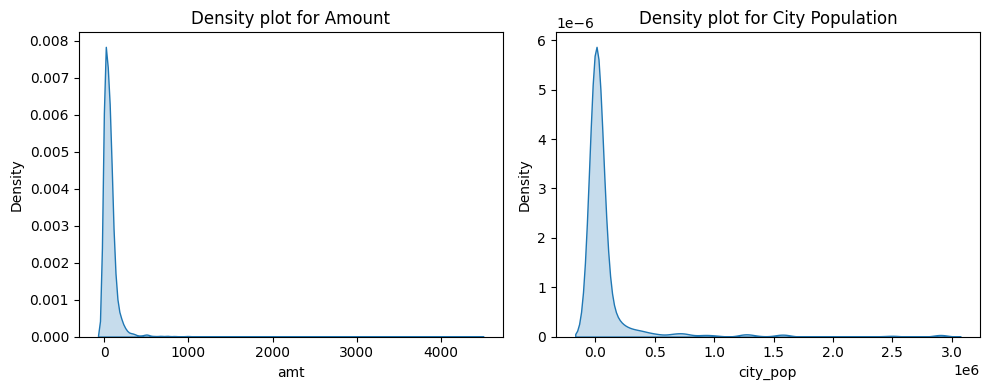

In [ ]:
#Plotting density plots for amount and city_pop in order to check for skewness
fig, ax = plt.subplots(1,2, figsize = (10,4))

sns.kdeplot(data=df.sample(n=5000, random_state=42)['amt'], fill=True, ax=ax[0])
ax[0].set_title('Density plot for Amount')

sns.kdeplot(data=df.sample(n=5000, random_state=42)['city_pop'], fill=True, ax=ax[1])
ax[1].set_title('Density plot for City Population')

plt.tight_layout()
plt.show()

We can see that these two distributions are highly skewed to the right. This indicates that it would be better to work with log of these features. By examining the density plots of the logarithmic values, log(x), we can verify the effect of this transformation.

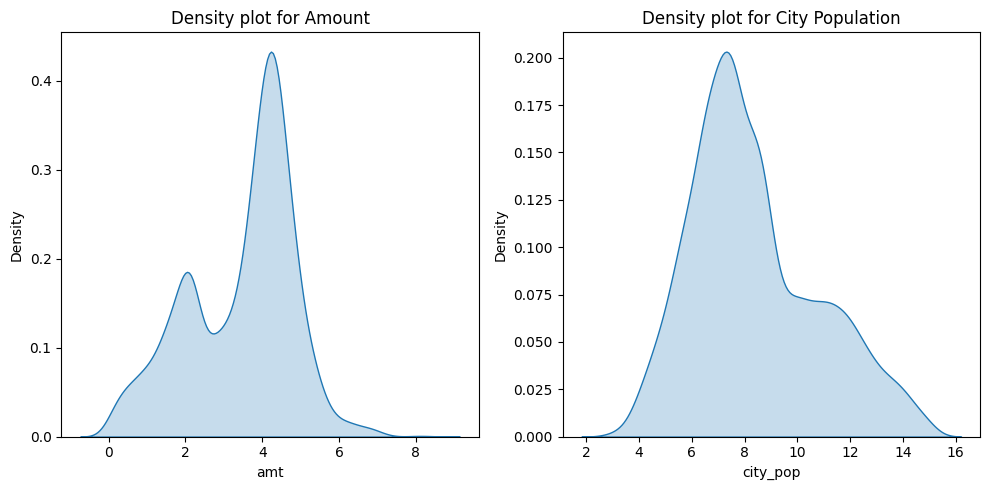

In [ ]:
#Plotting density plots for amount and city_pop in order to check for skewness
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.kdeplot(data = np.log(df.sample(n=5000, random_state=42)['amt']), fill=True, ax=ax[0])
ax[0].set_title('Density plot for Amount')
sns.kdeplot(data = np.log(df.sample(n=5000, random_state=42)['city_pop']), fill=True, ax=ax[1])
ax[1].set_title('Density plot for City Population')

plt.tight_layout()
plt.show()

Observing that the data exhibits more uniform distributions after applying a logarithmic transformation, we will proceed to convert these features to a log scale:

In [ ]:
df['amt'] = np.log(df['amt'])
df['city_pop'] = np.log(df['city_pop'])

##**2.4.- Correlations**

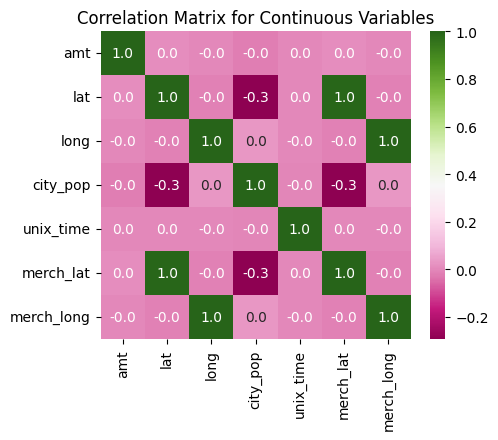

In [ ]:
#Filtering continous variables:
continuous_vars = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
df_continuous = df[continuous_vars]
corr_matrix = df_continuous.corr()

#Creating a heatmap:
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot = True, fmt = ".1f", cmap = 'PiYG', xticklabels = corr_matrix.columns, yticklabels = corr_matrix.columns)
plt.title('Correlation Matrix for Continuous Variables')
plt.show()

The variables that tend to be correlated with each other are **zip**, **lat**, and **long**, as they all geographically represent the location of the merchant or buyer. To avoid multicollinearity, we retain **lat** and **long** for geolocation purposes.

In [ ]:
df = df.drop(['zip', 'merch_lat', 'merch_long'], axis = 1)

After dropping these features, there are two important numeric features in our dataset: **amt** and **city_pop**. We create scatter plots to explore their relationship. Since the dataframe is too big to plot, we randomly sample 5000 rows and visualize them.

<Figure size 700x700 with 0 Axes>

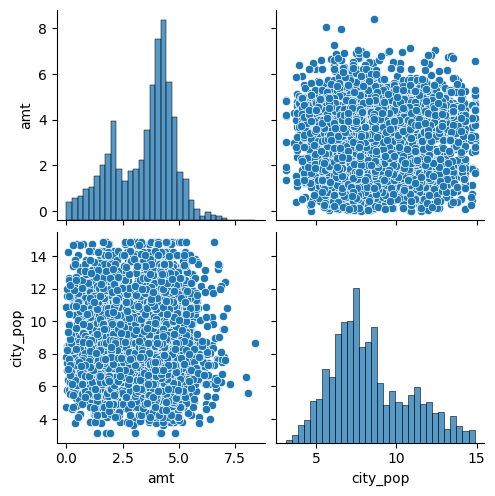

In [ ]:
plt.figure(figsize = (7,7))
continuous_vars = ['amt', 'city_pop']
sampled_df = df.sample(n = 5000, random_state = 42)
sns.pairplot(sampled_df[continuous_vars])
plt.show()

We can clearly see that there is no relationship at all between the amount of transactions and the city population, which was expected from intuition and from the correlation matrix.

# **3.- Data Cleaning and sampling**

##**3.1.- Missing Values: detection and strategies**

In [ ]:
df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
is_fraud                 0
dtype: int64

We can see that the dataset comes with no missing values, so we don't need to worry about handling missing values.

##**3.2.- Outliers**

We create the side-by-side boxplot to check for outliers of feature **amt** and **city_pop**.

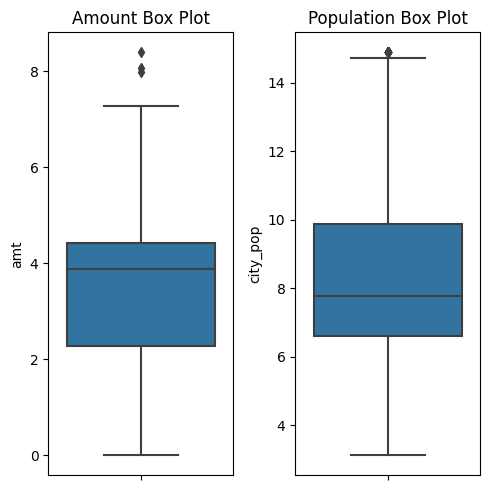

In [ ]:
#Plotting density plots for amount and city_pop in order to check for skewness
fig, ax = plt.subplots(1,2, figsize = (5,5))

sns.boxplot(y = df.sample(n=5000, random_state=42)['amt'], ax=ax[0])
ax[0].set_title('Amount Box Plot')

sns.boxplot(y = df.sample(n=5000, random_state=42)['city_pop'], ax=ax[1])
ax[1].set_title('Population Box Plot')

plt.tight_layout()
plt.show()

While the boxplots show the presence of outliers for both variables, these do not appear to be problematic.

##**3.3.- Feature Engineering**

We begin feature engineering by investigating whether there is a pattern in transaction timings for fraudulent activities.






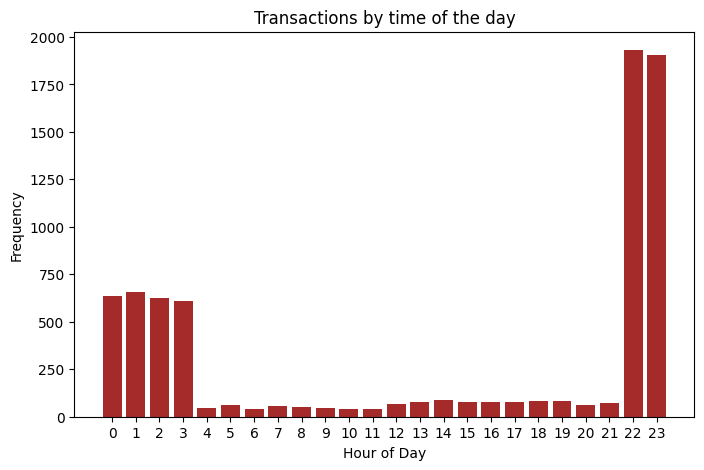

In [ ]:
#Extracting hour from trans_date_trans_time
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour

#For viz purposes:
df_viz = df.loc[df['is_fraud'] == 1].groupby('trans_hour').size().reset_index(name = 'frequency')
df_viz = df_viz.sort_values('trans_hour')

#Plotting:
plt.figure(figsize = (8,5))
plt.bar(df_viz['trans_hour'], df_viz['frequency'], color = 'brown')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Transactions by time of the day')
plt.xticks(df_viz['trans_hour'])
plt.show()

We can see that most of the fraudulent transactions occur between 10pm and 3am. This variable will take the value of 1 during the hours from 10:00 PM to 3:59 AM, indicative of a higher risk period, and 0 for all other times. This approach simplifies the daily time variable from 24 unique hourly cases to just 2 categories.

In [ ]:
df['risky_time'] = df['trans_hour'].apply(lambda x: 1 if (x >= 22 or x <= 3) else 0)

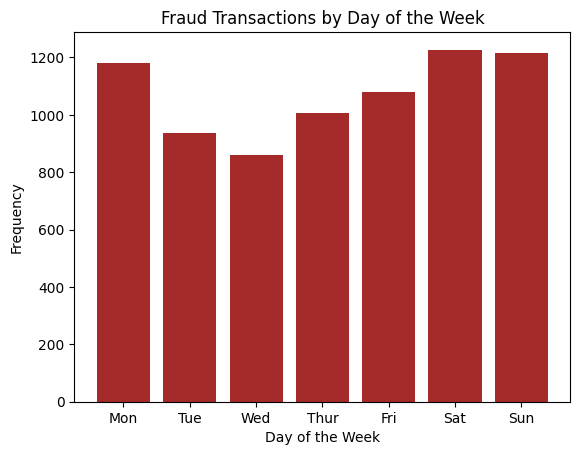

In [ ]:
#Extracting the day of the week:
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df_viz = df.loc[df['is_fraud'] == 1].groupby('trans_day_of_week').size().reset_index(name='frequency')
df_viz = df_viz.sort_values('trans_day_of_week')

#Plotting
plt.bar(df_viz['trans_day_of_week'], df_viz['frequency'], color = 'brown')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Fraud Transactions by Day of the Week')
plt.xticks(ticks = range(0, 7), labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

Let's also check if the age of the person carries more likelihood to be a victim of a fraudulent transaction.

In [ ]:
#Column dob is date of birth
df['dob'] = pd.to_datetime(df['dob'])
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

#It will be days / 365
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days / 365
df['age'] = df['age'].round(0).astype(int)

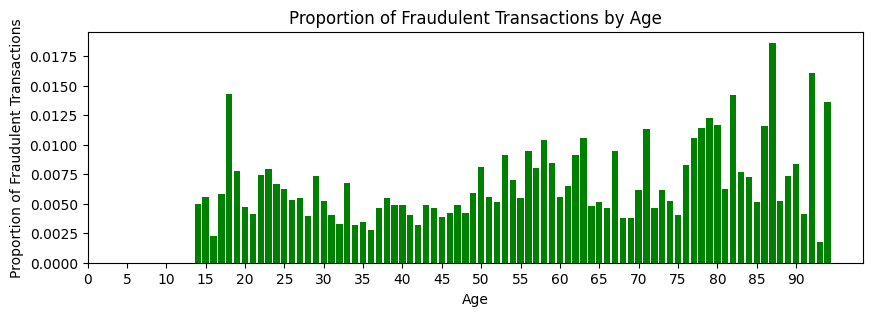

In [ ]:
#Total transactions per age:
total_count_per_age = df.groupby('age').size().reset_index(name='total_count')

#Fraudulent transactions by age:
fraud_count_per_age = df[df['is_fraud'] == 1].groupby('age').size().reset_index(name='fraud_count')
age_fraud_proportion = pd.merge(total_count_per_age, fraud_count_per_age, on='age')
age_fraud_proportion['fraud_proportion'] = age_fraud_proportion['fraud_count'] / age_fraud_proportion['total_count']

#Plotting:
plt.figure(figsize=(10, 3))
plt.bar(age_fraud_proportion['age'], age_fraud_proportion['fraud_proportion'], color='green')
plt.xlabel('Age')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Fraudulent Transactions by Age')
plt.xticks(range(0, int(age_fraud_proportion['age'].max()) + 1, 5))
plt.show()

There is no clear correlation between the two variables. We don't think it is necessary to create a variable for this feature. However, we are going to keep it as our intuition says that it might add explanatory power later.

So far the dataframe has the following columns:


In [ ]:
df = df.drop(['age','trans_num', 'city', 'street', 'state', 'last', 'first','merchant','cc_num','trans_date_trans_time', 'unix_time'], axis =1)
df['dob_int'] = df['dob'].apply(lambda x: x.year * 10000 + x.month * 100 + x.day)
df = df.drop(['dob'], axis=1)

print(f'Columns that will be used: {df.columns.values}')

Columns that will be used: ['category' 'amt' 'gender' 'lat' 'long' 'city_pop' 'job' 'is_fraud'
 'trans_hour' 'risky_time' 'trans_day_of_week' 'dob_int']


##**3.4.- Scaling/Encoding Data**

The features **amt**, **lat**, **long**, **city_pop**,  **unix_time**, **trans_hour**, **trans_day_of_week**, and **dob_int** are all numerical data, so they can be scaled using `StandardScaler`.

The features **gender** and **risky_time** are categorical with very few categories, so it makes sense to encode them using `OneHotEncoder`. Since these features are binary, we can drop the column representing the first feature value.

The features **category** and **job** are also categorical, but have more categories than the features that were encoded using one hot encoding. To save memory, it is reasonable to use `OrdinalEncoder` to encode these features.

In [ ]:
x_train = df.drop(['is_fraud'], axis=1)
y_train = df['is_fraud']

num_features = ['amt', 'lat', 'long', 'city_pop', 'trans_hour', 'trans_day_of_week', 'dob_int']
ohe_features = ['gender', 'risky_time']
ord_features = ['category', 'job']

preprocess = make_column_transformer((StandardScaler(), num_features),
                                     (OneHotEncoder(drop='if_binary'), ohe_features),
                                     (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_features))

train_X = preprocess.fit_transform(x_train)

##**3.5.- Handling Imbalanced Data**

In [ ]:
y_train.value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

The dataset is highly imbalanced, featuring 1,289,169 non-fraudulent to 7,506 fraudulent transactions, a common challenge in fraud detection. Standard classifiers may not perform well due to bias toward the majority class. Addressing this imbalance is crucial for improving fraud detection:

- **Random Oversampling**: balance an imbalanced dataset by randomly duplicating instances of the minority class, making it proportional to the majority class. This helps prevent a model from being biased towards the majority class.
- **Random Undersampling**: address class imbalance by randomly removing instances from the majority class, making it proportionate to the minority class. This helps prevent a model from being biased towards the majority class but may lead to loss of valuable information.
- **Ensemble Resampling**: combine ensemble techniques (like Random Forest) with resampling to address imbalanced datasets. It balances class distribution by creating multiple models on different subsets of resampled data, resulting in improved performance on imbalanced datasets.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: address class imbalance by generating synthetic examples for the minority class. It creates artificial data points by interpolating between existing instances to balance the dataset.
- **Adjusting Class Weights**: modify the loss function in machine learning algorithms. In the loss function, higher penalties are applied to errors on the minority class, effectively giving more weight to the minority class during training. This adjustment helps the model better handle class imbalances.

Using techniques like random oversampling and SMOTE can substantially increase the size of the training dataset, leading to higher computational demands.

In [ ]:
ros = RandomOverSampler(random_state = 42)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [ ]:
rus = RandomUnderSampler(replacement=False, random_state = 42)
x_train_rus, y_train_rus = ros.fit_resample(x_train, y_train)

In [ ]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = ros.fit_resample(x_train, y_train)

- Oversampling, including methods like SMOTE, increases the training dataset size, which may result in longer training times.
- Undersampling significantly decreases the dataset, possibly omitting valuable data and raising the risk of false positives.
- Adjusting class weights retains the original dataset size, emphasizing the minority class but it can also be slow to train.
- We plan to use random undersampling, adjust class weights, and apply ensemble methods to address class imbalance, while also considering the practicality of oversampling.

# **4.- Insights from data exploration**

- **Data Overview**:
The dataset contains 1,296,675 records of bank transactions from multiple sources, each with multiple features. Some of the key features include transaction amount, location of transaction, time at which transaction takes place, and the target variable indicating fraud or non-fraud.
- **Class Distribution**:
The dataset exhibits a significant class imbalance, with a much higher number of non-fraudulent transactions (99.4%) compared to fraudulent ones, as one would expect.
- **Feature Distributions**:
While some features such as gender and age have exhibited no particular imbalance, the same cannot be said about other categorical variables.
  - "Shop Category", shows a bias towards two particular values of the feature, namely "grocery pos" and "shopping net". Combinedly account for more than 45% of the occurrences. This means that most fraudulent transactions tend to occur at grocery stores (in person) and online.
  - 'Transaction amount' and 'city population', on the other hand, were found to be skewed to the right, with long-tailed distributions.
- **Correlations**:
Exploring correlations between features can uncover potential relationships.
Extensive correlation analysis on the features revealed a few Geographical features that had strong correlations with each other. Besides these, all other features were found to be independent of each other, thereby leading us to believe in their capability to contribute to improving the predictive power of the model.
- **Time Analysis**:
  - Analyzing temporal aspects of transactions, such as time of day or time since the dataset's start, can unveil time-based patterns related to fraud and usually is crucial for detecting fraudulent activities occurring at specific times.
  - One such insight was drawn by analyzing the hour data of the transactions, wherein it was observed that most of the events occurred between 10 PM and 3 AM.
  - The other time variable, 'day of the week' or 'month of the year', on the other hand, did not show significant differences to justifiy more features.
- **Anomalies and Outliers**:
Identifying and addressing anomalies and outliers is vital for robust fraud detection. Fortunately, on examining the continuous data features, no extreme anomalies were identified.
- **Feature Engineering Potential and Methodologies**:
  - Exploring feature interactions and the creation of new variables usually contributes to enhancing the model's performance.
  - Transaction amt and population were unskewed by applying log transformation to the variable values, and the subsequent values were found to follow multi-modal normal distributions.
  - Geovariables with high correlation were dropped from the dataset to maintain non-collinearity. To account for the extreme imbalance in the hours variable, a separate categorical feature was created indicating whether the transaction occurred during such a 'risky time' or not, thereby making the model training easier and more efficient.
- **Visualization**:
  - Visualizing data, especially fraud cases, can help identify clusters or patterns not apparent in summary statistics.
  - Interestingly, it was seen that fraud transactions turned out to be quite prevalent in the states of Texas, California, New York, Pennsylvania, and Ohio. Moreover, no state had zero-fraud rate, proving the ubiquitous nature of such activities, highlighting the need to develop robust fraud-detection models.
- **Feature Importance**:
It will be covered after fitting models. It is important to be able to have a sound interpretation of the model.
- **Missing Data**:
Identifying missing values and determining reasons for their absence is essential for data quality. Missing data can impact model performance, necessitating appropriate handling or imputation. Fortunately, our dataset has no missing values as such.
- **Cross-Validation Strategy**:
Choosing an appropriate cross-validation strategy is necessary due to class imbalance. Stratified K-fold cross-validation seems like the best choice for the case at hand, considering the high imbalance in the class labels.
- **Metrics to consider**:
  - Selecting appropriate evaluation metrics is crucial in defining the impact of the model on our designation objective. In the case of fraud detection, it is desired to decrease False Negatives as much as possible, since the cost of labeling fraudulent transactions as non-fraudulent is high.
  - We will focus on Recall to assess the performance of the model.
  - However it is also important to note that we cannot increased recall at whatever precision cost, since a reduction in precision would be perceived as a bad service by cardholders.

# **5.- Model Development**

We will import the dataset and transform according to our findings in the Explanatory Data Analysis section.

In [ ]:
#Mount the Drive
drive.mount('/content/drive', force_remount = True)

#Load Training Dataset
df1 = pd.read_csv('/content/drive/My Drive/AML Project/fraudTrain.csv')
df1 = df1.drop('Unnamed: 0', axis = 1)


#Load Development Dataset
df2 = pd.read_csv('/content/drive/My Drive/AML Project/fraudTest.csv')
df2 = df2.drop('Unnamed: 0', axis = 1)

Mounted at /content/drive


In [ ]:
#Creating the datasets
X_train = df1.drop(['is_fraud'], axis=1)
y_train = df1['is_fraud']
X_test = df2.drop(['is_fraud'], axis=1)
y_test = df2['is_fraud']

#Transforming the training dataset
X_train['amt'] = np.log(X_train['amt'])
X_train['city_pop'] = np.log(X_train['city_pop'])
X_train = X_train.drop(['zip', 'merch_lat', 'merch_long'], axis = 1)
X_train['trans_date_trans_time'] = pd.to_datetime(X_train['trans_date_trans_time'])
X_train['trans_hour'] = X_train['trans_date_trans_time'].dt.hour
X_train['risky_time'] = X_train['trans_hour'].apply(lambda x: 1 if (x >= 22 or x <= 3) else 0)
X_train = X_train.drop(['trans_num', 'city', 'street', 'state', 'last', 'first','merchant','cc_num','trans_date_trans_time', 'unix_time','job','trans_hour','dob'], axis =1)

#Transforming the test dataset
X_test['amt'] = np.log(X_test['amt'])
X_test['city_pop'] = np.log(X_test['city_pop'])
X_test = X_test.drop(['zip', 'merch_lat', 'merch_long'], axis = 1)
X_test['trans_date_trans_time'] = pd.to_datetime(X_test['trans_date_trans_time'])
X_test['trans_hour'] = X_test['trans_date_trans_time'].dt.hour
X_test['risky_time'] = X_test['trans_hour'].apply(lambda x: 1 if (x >= 22 or x <= 3) else 0)
X_test = X_test.drop(['trans_num', 'city', 'street', 'state', 'last', 'first','merchant','cc_num','trans_date_trans_time', 'unix_time','job','trans_hour','dob'], axis =1)

#Creating the calibration set from train:
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42, stratify = y_train)

In [ ]:
X_train.head()

,category,amt,gender,lat,long,city_pop,risky_time
267436,kids_pets,4.928847,M,43.4269,-85.2924,8.406038,0
233159,kids_pets,2.568788,F,37.9048,-86.5240,5.840642,0
430072,gas_transport,4.512507,M,41.2244,-86.6966,8.664060,1
236662,kids_pets,4.850388,F,43.6498,-116.4306,11.339833,1
450357,home,4.722420,M,41.1410,-84.5722,8.745762,0


In [ ]:
#Let's see the dimensions
print(f'Proportion of Training data: {X_train.shape[0]/(X_train.shape[0]+X_cal.shape[0]+X_test.shape[0]):0.1f}')
print(f'Proportion of Calibration data: {X_cal.shape[0]/(X_train.shape[0]+X_cal.shape[0]+X_test.shape[0]):0.1f}')
print(f'Proportion of Test data: {X_test.shape[0]/(X_train.shape[0]+X_cal.shape[0]+X_test.shape[0]):0.1f}')

Proportion of Training data: 0.5
Proportion of Calibration data: 0.2
Proportion of Test data: 0.3


In [ ]:
#Encoding
num_features = ['amt', 'lat', 'long', 'city_pop']
ohe_features = ['gender', 'risky_time']
ord_features = ['category']

preprocess = make_column_transformer((StandardScaler(), num_features),
                                     (OneHotEncoder(drop='if_binary'), ohe_features),
                                     (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_features))
X_train = preprocess.fit_transform(X_train)
X_cal = preprocess.transform(X_cal)
X_test = preprocess.transform(X_test)
feature_names_ = preprocess.get_feature_names_out()

In [ ]:
#This function will give us metrics that we are interested in
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    return {
        "Recall": recall_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, model.predict_proba(X)[:, 1]),
        "Precision": precision_score(y, y_pred)
    }

## **5.1.- Decision Tree**

### **5.1.1.- Baseline**

We will begin by finding a Decision Tree Classifier that will act as a baseline model.

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_split': [2, 5, 10, 20]
}

# Baseline Decision Tree Classifier
dtc_baseline = DecisionTreeClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(dtc_baseline, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on training data
train_metrics = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics:")
print(f"ROC AUC: {train_metrics['ROC AUC']}")
print(f"Precision: {train_metrics['Precision']}")
print(f"Recall: {train_metrics['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")

Best parameters: {'max_depth': 10, 'min_samples_split': 5}
Training Metrics:
ROC AUC: 0.9964956217615403
Precision: 0.900679117147708
Recall: 0.7539527447148694

Validation Metrics:
ROC AUC: 0.9737166515738125
Precision: 0.7799043062200957
Recall: 0.6839160839160839


### **5.1.2.- Random Oversampling**

In [ ]:
import time
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Start timing
start_time = time.time()

# Oversampling on the training data
ros = RandomOverSampler(random_state=42)

# Define the parameter grid with the correct naming for pipeline steps
param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 20, 40, 60],
    'decisiontreeclassifier__min_samples_split': [1, 2, 5, 10, 20]
}

# Baseline Decision Tree Classifier
dtc_over = DecisionTreeClassifier(random_state=42)
pipeline_over_dtc = imb_make_pipeline(ros, dtc_over)

# GridSearchCV with oversampled training data
grid_search = GridSearchCV(pipeline_over_dtc, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model using oversampled data
best_model = grid_search.best_estimator_

# Evaluate the best model on training data (post-oversampling)
train_metrics_oversampled = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (Oversampled):")
print(f"ROC AUC: {train_metrics_oversampled['ROC AUC']}")
print(f"Precision: {train_metrics_oversampled['Precision']}")
print(f"Recall: {train_metrics_oversampled['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")

# Capture end time and calculate duration
end_time = time.time()
duration = end_time - start_time
print(f"Time taken to execute the code: {duration/60} minutes")


Best parameters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 2}
Training Metrics (Oversampled):
ROC AUC: 0.9978647634567629
Precision: 0.1668162776780371
Recall: 0.9904068218155978

Validation Metrics:
ROC AUC: 0.9746222030332193
Precision: 0.11220266019095977
Recall: 0.9477855477855478
Time taken to execute the code: 2.3840426286061605 minutes


### **5.1.3.- Random Undersampling**

In [ ]:
# Undersampling on the training data
rus = RandomUnderSampler(random_state=42)

# Define the parameter grid
param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 20, 40],
    'decisiontreeclassifier__min_samples_split': [5, 10, 20, 30, 45, 60]
}

# Decision Tree Classifier with undersampling
dtc_under = DecisionTreeClassifier(random_state=42)
pipeline_under_dtc = imb_make_pipeline(rus, dtc_under)

# GridSearchCV with undersampled training data
grid_search = GridSearchCV(pipeline_under_dtc, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model using undersampled data
best_model = grid_search.best_estimator_

# Evaluate the best model on training data (post-undersampling)
train_metrics_undersampled = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (Undersampled):")
print(f"ROC AUC: {train_metrics_undersampled['ROC AUC']}")
print(f"Precision: {train_metrics_undersampled['Precision']}")
print(f"Recall: {train_metrics_undersampled['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")


Best parameters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 20}
Training Metrics (Undersampled):
ROC AUC: 0.9928084888613291
Precision: 0.1116596807996131
Recall: 0.9843666725883816

Validation Metrics:
ROC AUC: 0.9821061444477646
Precision: 0.07485465116279069
Recall: 0.9603729603729604


### **5.1.4.- Smote**

In [ ]:
# SMOTE for oversampling the training data
smote = SMOTE(random_state=42)

# Define the parameter grid with the correct naming for pipeline steps
param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 20, 40],
    'decisiontreeclassifier__min_samples_split': [10, 20, 25, 30]
}

# Decision Tree Classifier for SMOTE
dtc_smote = DecisionTreeClassifier(random_state=42)
pipeline_smote_dtc = imb_make_pipeline(smote, dtc_smote)

# GridSearchCV with SMOTE training data
grid_search = GridSearchCV(pipeline_smote_dtc, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model using SMOTE data
best_model = grid_search.best_estimator_

# Evaluate the best model on training data (post-SMOTE)
train_metrics_smote = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (SMOTE):")
print(f"ROC AUC: {train_metrics_smote['ROC AUC']}")
print(f"Precision: {train_metrics_smote['Precision']}")
print(f"Recall: {train_metrics_smote['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")


Best parameters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 10}
Training Metrics (SMOTE):
ROC AUC: 0.9971141437059369
Precision: 0.22165889271952952
Recall: 0.9708651625510748

Validation Metrics:
ROC AUC: 0.9828578627395047
Precision: 0.15443192202254036
Recall: 0.9454545454545454


### **5.1.5.- Adjust Class Weight**

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Decision Tree Classifier with balanced class weight
dtc_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# GridSearchCV for the balanced class weight model
grid_search = GridSearchCV(dtc_balanced, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on training data
train_metrics_balanced = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (Balanced):")
print(f"ROC AUC: {train_metrics_balanced['ROC AUC']}")
print(f"Precision: {train_metrics_balanced['Precision']}")
print(f"Recall: {train_metrics_balanced['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")


Best parameters: {'max_depth': 10, 'min_samples_leaf': 8}
Training Metrics (Balanced):
ROC AUC: 0.9979352924285417
Precision: 0.17254610719148408
Recall: 0.9905844732634571

Validation Metrics:
ROC AUC: 0.9785922586724286
Precision: 0.11755909587622937
Recall: 0.9529137529137529


### **5.1.6.- Decision Tree Results**
| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'max_depth': 10, 'min_samples_split': 5} |  0.68 |  0.97| 0.78|
| Random Oversampling | {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 2} | 0.95 | 0.97|0.11 |
| Random Undersampling |{'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 20} |0.96 |0.98| 0.07 |
| SMOTE |{{'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_split': 10}} |0.95 | 0.98 | 0.15 |
| Balanced Weight |{'max_depth': 10, 'min_samples_leaf': 8}  | 0.95 | 0.98 | 0.12 |

In [ ]:
#Creating a dataframe with the results:
data = {
    "Sampling Method": ["Default Baseline", "Random Oversampling", "Random Undersampling", "SMOTE", "Balanced Weight"],
    "Recall": [0.68, 0.95, 0.96, 0.95, 0.95],
    "AUC ROC": [0.97, 0.97, 0.98, 0.98, 0.98],
    "Precision": [0.78, 0.11, 0.07, 0.15, 0.12]
}
all_models = pd.DataFrame(data)
all_models["Model"] = 'Decision Tree'

## **5.2.- KNN**

### **5.2.1.- Baseline**

In [ ]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [5, 10, 20, 30, 40]
}

# Baseline KNN
knn = KNeighborsClassifier()

# GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on training data
train_metrics = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics:")
print(f"ROC AUC: {train_metrics['ROC AUC']}")
print(f"Precision: {train_metrics['Precision']}")
print(f"Recall: {train_metrics['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")

Best parameters: {'n_neighbors': 5}
Training Metrics:
ROC AUC: 0.9991359451997587
Precision: 0.8748271092669433
Recall: 0.6741872446260437

Validation Metrics:
ROC AUC: 0.8728981382543508
Precision: 0.722822631913541
Recall: 0.5300699300699301


### **5.2.2.- Random Oversampling**

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with the correct step name
param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 30, 40]
}

# Create a pipeline with RandomOverSampler and KNN
pipeline_over_knn = imb_make_pipeline(RandomOverSampler(random_state=42), KNeighborsClassifier())

# GridSearchCV with oversampled training data
grid_search = GridSearchCV(pipeline_over_knn, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the oversampled data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model using oversampled data
best_model = grid_search.best_estimator_

# Function 'calculate_metrics' needs to be defined to evaluate the model.
# Assume it returns a dictionary with 'ROC AUC', 'Precision', and 'Recall'.

# Evaluate the best model on oversampled training data
train_metrics_oversampled = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (Oversampled):")
print(f"ROC AUC: {train_metrics_oversampled['ROC AUC']}")
print(f"Precision: {train_metrics_oversampled['Precision']}")
print(f"Recall: {train_metrics_oversampled['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")

Best parameters: {'kneighborsclassifier__n_neighbors': 40}
Training Metrics (Oversampled):
ROC AUC: 0.9999997043665537
Precision: 0.24470721210276922
Recall: 1.0

Validation Metrics:
ROC AUC: 0.9401451645982639
Precision: 0.14878048780487804
Recall: 0.8531468531468531


### **5.2.3.- Random Undersampling**

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with the correct step name
param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 30, 40]
}

# Create a pipeline with RandomUnderSampler and KNN
pipeline_under_knn = imb_make_pipeline(RandomUnderSampler(random_state=42), KNeighborsClassifier())

# GridSearchCV with undersampled training data
grid_search = GridSearchCV(pipeline_under_knn, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the undersampled data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model using undersampled data
best_model = grid_search.best_estimator_

# Function 'calculate_metrics' needs to be defined to evaluate the model.
# Assume it returns a dictionary with 'ROC AUC', 'Precision', and 'Recall'.

# Evaluate the best model on undersampled training data
train_metrics_undersampled = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (Undersampled):")
print(f"ROC AUC: {train_metrics_undersampled['ROC AUC']}")
print(f"Precision: {train_metrics_undersampled['Precision']}")
print(f"Recall: {train_metrics_undersampled['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")


Best parameters: {'kneighborsclassifier__n_neighbors': 5}
Training Metrics (Undersampled):
ROC AUC: 0.9826761796338073
Precision: 0.06879241542332816
Recall: 0.9616272872623912

Validation Metrics:
ROC AUC: 0.9687898227565913
Precision: 0.045485636114911084
Recall: 0.9300699300699301


### **5.2.4.- Smote**

In [ ]:
# Define the parameter grid
param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 30, 40]
}

# Create a pipeline with SMOTE and KNN
pipeline_smote_knn = imb_make_pipeline(SMOTE(random_state=42), KNeighborsClassifier())

# GridSearchCV with SMOTE training data
grid_search = GridSearchCV(pipeline_under_knn, param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the SMOTE data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate the best model using SMOTE data
best_model = grid_search.best_estimator_

# Evaluate the best model on SMOTE training data
train_metrics_smote = calculate_metrics(best_model, X_train, y_train)
print("Training Metrics (SMOTE):")
print(f"ROC AUC: {train_metrics_smote['ROC AUC']}")
print(f"Precision: {train_metrics_smote['Precision']}")
print(f"Recall: {train_metrics_smote['Recall']}")

# Evaluate the best model on validation data
validation_metrics = calculate_metrics(best_model, X_test, y_test)
print("\nValidation Metrics:")
print(f"ROC AUC: {validation_metrics['ROC AUC']}")
print(f"Precision: {validation_metrics['Precision']}")
print(f"Recall: {validation_metrics['Recall']}")

Best parameters: {'kneighborsclassifier__n_neighbors': 5}
Training Metrics (SMOTE):
ROC AUC: 0.9826761796338073
Precision: 0.06879241542332816
Recall: 0.9616272872623912

Validation Metrics:
ROC AUC: 0.9687898227565913
Precision: 0.045485636114911084
Recall: 0.9300699300699301


### **5.2.5.- KNN Results**
| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'n_neighbors': 5} |  0.53|  0.87 | 0.82|
| Random Oversampling | {'n_neighbors': 5} |  0.85|  0.94 | 0.15|
| Random Undersampling | {'n_neighbors': 5} |  0.93|  0.97 | 0.05|
| SMOTE | {'n_neighbors': 5} |  0.93|  0.97 | 0.05|

We believe that the best model is random undersampling, which had a 93% recall score, though this came at the cost of a low precision score of 5%. However, it underperforms in both recall and precision compared to the best decision tree model.

In [ ]:
data = {
    "Sampling Method": ["Default Baseline", "Random Oversampling", "Random Undersampling", "SMOTE"],
    "Recall": [0.53, 0.85, 0.93, 0.93],
    "AUC ROC": [0.87, 0.94, 0.97, 0.97],
    "Precision": [0.82, 0.15, 0.05, 0.05]
}
data = pd.DataFrame(data)
data["Model"] = 'KNN'
all_models = all_models.append(data)

## **5.3.- Logistic Regression**

### **5.3.1.- Baseline**

In [ ]:
# Define the parameter grid
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 20)
}

# Baseline Logistic Classifier
lr_baseline = LogisticRegression(random_state=42)

# GridSearchCV
grid_search_lr = GridSearchCV(lr_baseline, param_grid_lr, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid
grid_search_lr.fit(X_train, y_train)

# Get the best parameters
best_params_lr = grid_search_lr.best_params_
print("Best parameters:", best_params_lr)

# Evaluate the best model
best_model_lr = grid_search_lr.best_estimator_

# Evaluate the best model on training data
train_metrics_lr = calculate_metrics(best_model_lr, X_train, y_train)
print("Training Metrics for LogisticRegression:")
print(f"ROC AUC: {train_metrics_lr['ROC AUC']}")
print(f"Precision: {train_metrics_lr['Precision']}")
print(f"Recall: {train_metrics_lr['Recall']}")

# Evaluate the best model on validation data
validation_metrics_lr = calculate_metrics(best_model_lr, X_test, y_test)
print("\nValidation Metrics for LogisticRegression:")
print(f"ROC AUC: {validation_metrics_lr['ROC AUC']}")
print(f"Precision: {validation_metrics_lr['Precision']}")
print(f"Recall: {validation_metrics_lr['Recall']}")

Best parameters: {'C': 1.623776739188721, 'penalty': 'l2'}
Training Metrics for LogisticRegression:
ROC AUC: 0.8953097967439709
Precision: 0.15206185567010308
Recall: 0.010481435423698704

Validation Metrics for LogisticRegression:
ROC AUC: 0.8942510736104727
Precision: 0.10891089108910891
Recall: 0.010256410256410256


### **5.3.2.- Random Oversampling**

In [ ]:
# Define the parameter grid for LogisticRegression
param_grid_lr = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-4, 4, 20),
}


# Create a pipeline with RandomOverSampler and LogisticRegression
pipeline_over_lr = imb_make_pipeline(RandomOverSampler(random_state=42), LogisticRegression(random_state=42))

# GridSearchCV with the pipeline
grid_search_over_lr = GridSearchCV(pipeline_over_lr, param_grid_lr, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
grid_search_over_lr.fit(X_train, y_train)

# Get the best parameters
best_params_over_lr = grid_search_over_lr.best_params_
print("Best parameters:", best_params_over_lr)

# Evaluate the best model
best_model_over_lr = grid_search_over_lr.best_estimator_

# Calculate and print training metrics
train_metrics_over_lr = calculate_metrics(best_model_over_lr, X_train, y_train)
print("\nTraining Metrics (Oversampling) for LogisticRegression:")
print(f"ROC AUC: {train_metrics_over_lr['ROC AUC']}")
print(f"Precision: {train_metrics_over_lr['Precision']}")
print(f"Recall: {train_metrics_over_lr['Recall']}")

# Calculate and print validation metrics
validation_metrics_over_lr = calculate_metrics(best_model_over_lr, X_test, y_test)
print("\nValidation Metrics (Oversampling) for LogisticRegression:")
print(f"ROC AUC: {validation_metrics_over_lr['ROC AUC']}")
print(f"Precision: {validation_metrics_over_lr['Precision']}")
print(f"Recall: {validation_metrics_over_lr['Recall']}")

Best parameters: {'logisticregression__C': 0.03359818286283781, 'logisticregression__penalty': 'l2'}

Training Metrics (Oversampling) for LogisticRegression:
ROC AUC: 0.9144649449511149
Precision: 0.026309106021425933
Recall: 0.8097352993426896

Validation Metrics (Oversampling) for LogisticRegression:
ROC AUC: 0.9126758950397705
Precision: 0.01758344513558564
Recall: 0.8065268065268065


### **5.3.3.- Random Undersampling**

In [ ]:
# Define the parameter grid for LogisticRegression
param_grid_lr = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-4, 4, 20),
}


# Create a pipeline with RandomUnderSampler and LogisticRegression
pipeline_under_lr = imb_make_pipeline(RandomUnderSampler(random_state=42), LogisticRegression(random_state=42))

# GridSearchCV with the pipeline
grid_search_under_lr = GridSearchCV(pipeline_under_lr, param_grid_lr, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
grid_search_under_lr.fit(X_train, y_train)

# Get the best parameters
best_params_under_lr = grid_search_under_lr.best_params_
print("Best parameters:", best_params_under_lr)

# Evaluate the best model
best_model_under_lr = grid_search_under_lr.best_estimator_

# Calculate and print training metrics
train_metrics_under_lr = calculate_metrics(best_model_under_lr, X_train, y_train)
print("\nTraining Metrics (Undersampling) for LogisticRegression:")
print(f"ROC AUC: {train_metrics_under_lr['ROC AUC']}")
print(f"Precision: {train_metrics_under_lr['Precision']}")
print(f"Recall: {train_metrics_under_lr['Recall']}")

# Calculate and print validation metrics
validation_metrics_under_lr = calculate_metrics(best_model_under_lr, X_test, y_test)
print("\nValidation Metrics (Undersampling) for LogisticRegression:")
print(f"ROC AUC: {validation_metrics_under_lr['ROC AUC']}")
print(f"Precision: {validation_metrics_under_lr['Precision']}")
print(f"Recall: {validation_metrics_under_lr['Recall']}")

Best parameters: {'logisticregression__C': 4.281332398719396, 'logisticregression__penalty': 'l2'}

Training Metrics (Undersampling) for LogisticRegression:
ROC AUC: 0.9142862789054369
Precision: 0.026274055235491887
Recall: 0.809379996446971

Validation Metrics (Undersampling) for LogisticRegression:
ROC AUC: 0.9125414872424306
Precision: 0.017524966727961718
Recall: 0.8041958041958042


### **5.3.4.- Smote**

In [ ]:
# Define the parameter grid for LogisticRegression
param_grid_lr = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-4, 4, 20),
}


# Create a pipeline with SMOTE and LogisticRegression
pipeline_SMOTE_lr = imb_make_pipeline(SMOTE(random_state=42), LogisticRegression(random_state=42))

# GridSearchCV with the pipeline
grid_search_SMOTE_lr = GridSearchCV(pipeline_SMOTE_lr, param_grid_lr, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
grid_search_SMOTE_lr.fit(X_train, y_train)

# Get the best parameters
best_params_SMOTE_lr = grid_search_SMOTE_lr.best_params_
print("Best parameters:", best_params_SMOTE_lr)

# Evaluate the best model
best_model_SMOTE_lr = grid_search_SMOTE_lr.best_estimator_

# Calculate and print training metrics
train_metrics_SMOTE_lr = calculate_metrics(best_model_SMOTE_lr, X_train, y_train)
print("\nTraining Metrics (SMOTE):")
print(f"ROC AUC: {train_metrics_SMOTE_lr['ROC AUC']}")
print(f"Precision: {train_metrics_SMOTE_lr['Precision']}")
print(f"Recall: {train_metrics_SMOTE_lr['Recall']}")

# Calculate and print validation metrics
validation_metrics_SMOTE_lr = calculate_metrics(best_model_SMOTE_lr, X_test, y_test)
print("\nValidation Metrics (SMOTE):")
print(f"ROC AUC: {validation_metrics_SMOTE_lr['ROC AUC']}")
print(f"Precision: {validation_metrics_SMOTE_lr['Precision']}")
print(f"Recall: {validation_metrics_SMOTE_lr['Recall']}")

Best parameters: {'logisticregression__C': 0.03359818286283781, 'logisticregression__penalty': 'l2'}

Training Metrics (SMOTE):
ROC AUC: 0.913984805917744
Precision: 0.02639686035153428
Recall: 0.8113341623734234

Validation Metrics (SMOTE):
ROC AUC: 0.9120776456794767
Precision: 0.017745749582093205
Recall: 0.8116550116550116


### **5.3.5.- Adjust Class Weight**

In [ ]:
# Define the parameter grid for LogisticRegression
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 20)
}

# LogisticRegression with balanced class weight
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42)

# GridSearchCV for the balanced class weight model
grid_search_lr_balanced = GridSearchCV(lr_balanced, param_grid_lr, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for LogisticRegression
grid_search_lr_balanced.fit(X_train, y_train)

# Get the best parameters for LogisticRegression
best_params_lr_balanced = grid_search_lr_balanced.best_params_
print("Best parameters for LogisticRegression (Balanced):", best_params_lr_balanced)

# Evaluate the best model for LogisticRegression
best_model_lr_balanced = grid_search_lr_balanced.best_estimator_

# Evaluate the best model on training data for LogisticRegression
train_metrics_lr_balanced = calculate_metrics(best_model_lr_balanced, X_train, y_train)
print("\nTraining Metrics (Balanced) for LogisticRegression:")
print(f"ROC AUC: {train_metrics_lr_balanced['ROC AUC']}")
print(f"Precision: {train_metrics_lr_balanced['Precision']}")
print(f"Recall: {train_metrics_lr_balanced['Recall']}")

# Evaluate the best model on validation data for LogisticRegression
validation_metrics_lr_balanced = calculate_metrics(best_model_lr_balanced, X_test, y_test)
print("\nValidation Metrics (Balanced) for LogisticRegression:")
print(f"ROC AUC: {validation_metrics_lr_balanced['ROC AUC']}")
print(f"Precision: {validation_metrics_lr_balanced['Precision']}")
print(f"Recall: {validation_metrics_lr_balanced['Recall']}")


Best parameters for LogisticRegression (Balanced): {'C': 0.615848211066026, 'penalty': 'l2'}

Training Metrics (Balanced) for LogisticRegression:
ROC AUC: 0.9144054983750852
Precision: 0.026299553120945653
Recall: 0.8102682536862675

Validation Metrics (Balanced) for LogisticRegression:
ROC AUC: 0.9126285215926347
Precision: 0.01758643448240849
Recall: 0.8074592074592074


### **5.3.6.- Logistic Regression Model Results**

| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'penalty': l2, 'C': 100} | 0.01 |0.89  |0.11 |
| Random Oversampling |{'penalty': l2, 'C': 0.03359818286283781} | 0.81 | 0.91  |0.02 |
| Random Undersampling |{'penalty': l2, 'C': 4.281332398719396} | 0.80 | 0.91 | 0.02 |
| SMOTE |{'penalty': l2, 'C': 0.03359818286283781} | 0.81 | 0.91 |0.02 |
| Balanced Weight | {'penalty': l2, 'C': 0.615848211066026} | 0.81 | 0.91 | 0.02 |

In [ ]:
data = {
    "Sampling Method": ["Default Baseline", "Random Oversampling", "Random Undersampling", "SMOTE", "Balanced Weight"],
    "Recall": [0.01, 0.81, 0.80, 0.81, 0.81],
    "AUC ROC": [0.89, 0.91, 0.91, 0.91, 0.91],
    "Precision": [0.11, 0.02, 0.02, 0.02, 0.02]
}

data = pd.DataFrame(data)
data["Model"] = 'Logistic Regression'
all_models = all_models.append(data)

We beleive the SMOTE sampling method with the logistic regression model is the best. We can see that the random oversampling, SMOTE, and balanced weight all generate similar validation recall, AUC ROC, and Precision, but the recall of SMOTE is 0.8117, which is slightly higher than the other two.

## **5.4.- SVM**


### **5.4.1.- Baseline**

Due to computational limitations and the size of our dataset (over 1 million rows for training), we had to omit Random Oversampling for this model. Our traning time was around 3 hours, and this technique would have extended this even further. Even though the model could have carried good results for Recall and Precision, in practice, the resources to allocate to run this model could go beyond the benefits that it carries. Given these constraints, Random Oversampling was impractical for this case and we omitted it.

### **5.4.2.- Random Undersampling**

In [ ]:
# Define the parameter grid for SVM
param_grid_svm = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'poly']
}
# Create a pipeline with RandomUnderSampler and SVM
pipeline_under_svm = imb_make_pipeline(RandomUnderSampler(random_state=42), SVC(probability=True, random_state=42))

# GridSearchCV with the pipeline
grid_search_under_svm = GridSearchCV(pipeline_under_svm, param_grid_svm, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
grid_search_under_svm.fit(X_train, y_train)

# Get the best parameters
best_params_under_svm = grid_search_under_svm.best_params_
print("Best parameters:", best_params_under_svm)

# Evaluate the best model
best_model_under_svm = grid_search_under_svm.best_estimator_

# Calculate and print training metrics
train_metrics_under_svm = calculate_metrics(best_model_under_svm, X_train, y_train)
print("\nTraining Metrics (Undersampling) for SVM:")
print(f"ROC AUC: {train_metrics_under_svm['ROC AUC']}")
print(f"Precision: {train_metrics_under_svm['Precision']}")
print(f"Recall: {train_metrics_under_svm['Recall']}")

# Calculate and print validation metrics
validation_metrics_under_svm = calculate_metrics(best_model_under_svm, X_test, y_test)
print("\nValidation Metrics (Undersampling) for SVM:")
print(f"ROC AUC: {validation_metrics_under_svm['ROC AUC']}")
print(f"Precision: {validation_metrics_under_svm['Precision']}")
print(f"Recall: {validation_metrics_under_svm['Recall']}")

Best parameters: {'svc__C': 1, 'svc__kernel': 'linear'}

Training Metrics (Undersampling) for SVM:
ROC AUC: 0.9118649640571758
Precision: 0.027262255215666196
Recall: 0.7566607460035524

Validation Metrics (Undersampling) for SVM:
ROC AUC: 0.9107494109179854
Precision: 0.018124507486209612
Recall: 0.7523364485981309


### **5.4.3.- Adjust Class Weights**

Due to computational limitations and the size of our dataset (over 1 million rows for training), we had to omit Random Oversampling for this model. Our traning time was around 3 hours, and this technique would have extended this even further. Even though the model could have carried good results for Recall and Precision, in practice, the resources to allocate to run this model could go beyond the benefits that it carries. Given these constraints, Random Oversampling was impractical for this case and we omitted it.

### **5.4.4.- SVM Results**

| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Random Undersampling |{'C': 1, 'kernel: linear'} | 0.75 | 0.91 | 0.02 |

In [ ]:
data = {
    "Sampling Method": ["Random Undersampling"],
    "Recall": [0.75],
    "AUC ROC": [0.91],
    "Precision": [0.02]
}

data = pd.DataFrame(data)
data["Model"] = 'SVM'
all_models = all_models.append(data)

## **5.5.- Random Forest**

### **5.5.1 Baseline**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Baseline RandomForestClassifier
rf_classifier = RandomForestClassifier()

# GridSearchCV
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid for RandomForestClassifier
grid_search_rf.fit(X_train, y_train)

# Get the best parameters for RandomForestClassifier
best_params_rf = grid_search_rf.best_params_
print("Best parameters for RandomForestClassifier:", best_params_rf)

# Evaluate the best model for RandomForestClassifier
best_model_rf = grid_search_rf.best_estimator_

# Evaluate the best model on training data for RandomForestClassifier
train_metrics_rf = calculate_metrics(best_model_rf, X_train, y_train)
print("\nTraining Metrics for RandomForestClassifier:")
print(f"ROC AUC: {train_metrics_rf['ROC AUC']}")
print(f"Precision: {train_metrics_rf['Precision']}")
print(f"Recall: {train_metrics_rf['Recall']}")

# Evaluate the best model on validation data for RandomForestClassifier
validation_metrics_rf = calculate_metrics(best_model_rf, X_test, y_test)
print("\nValidation Metrics for RandomForestClassifier:")
print(f"ROC AUC: {validation_metrics_rf['ROC AUC']}")
print(f"Precision: {validation_metrics_rf['Precision']}")
print(f"Recall: {validation_metrics_rf['Recall']}")


Best parameters for RandomForestClassifier: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 50}

Training Metrics for RandomForestClassifier:
ROC AUC: 0.9999732156832651
Precision: 0.9841982052282482
Recall: 0.8962515544501688

Validation Metrics for RandomForestClassifier:
ROC AUC: 0.9696982013628027
Precision: 0.8251333728512151
Recall: 0.6489510489510489


### **5.5.2.- Random Oversampling**

Due to computational limitations and the size of our dataset (over 1 million rows for training), we had to omit Random Oversampling for this model. Our traning time was around 3 hours, and this technique would have extended this even further. Even though the model could have carried good results for Recall and Precision, in practice, the resources to allocate to run this model could go beyond the benefits that it carries. Given these constraints, Random Oversampling was impractical for this case and we omitted it.

### **5.5.3.- Random Undersampling**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [1, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

# Create a pipeline with RandomUnderSampler and RandomForestClassifier
pipeline_under_rf = imb_make_pipeline(RandomUnderSampler(random_state=42), RandomForestClassifier(random_state=42))

# GridSearchCV with the pipeline for RandomForestClassifier
grid_search_under_rf = GridSearchCV(pipeline_under_rf, param_grid_rf, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for RandomForestClassifier
grid_search_under_rf.fit(X_train, y_train)

# Get the best parameters for RandomForestClassifier
best_params_under_rf = grid_search_under_rf.best_params_
print("Best parameters for RandomForestClassifier (Undersampling):", best_params_under_rf)

# Evaluate the best model for RandomForestClassifier
best_model_under_rf = grid_search_under_rf.best_estimator_

# Calculate and print training metrics for RandomForestClassifier
train_metrics_under_rf = calculate_metrics(best_model_under_rf, X_train, y_train)
print("\nTraining Metrics (Undersampling) for RandomForestClassifier:")
print(f"ROC AUC: {train_metrics_under_rf['ROC AUC']}")
print(f"Precision: {train_metrics_under_rf['Precision']}")
print(f"Recall: {train_metrics_under_rf['Recall']}")

# Calculate and print validation metrics for RandomForestClassifier
validation_metrics_under_rf = calculate_metrics(best_model_under_rf, X_test, y_test)
print("\nValidation Metrics (Undersampling) for RandomForestClassifier:")
print(f"ROC AUC: {validation_metrics_under_rf['ROC AUC']}")
print(f"Precision: {validation_metrics_under_rf['Precision']}")
print(f"Recall: {validation_metrics_under_rf['Recall']}")


Best parameters for RandomForestClassifier (Undersampling): {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 150}

Training Metrics (Undersampling) for RandomForestClassifier:
ROC AUC: 0.9987756626535366
Precision: 0.16015135996358257
Recall: 1.0

Validation Metrics (Undersampling) for RandomForestClassifier:
ROC AUC: 0.991397669796041
Precision: 0.10765007127395597
Recall: 0.9505827505827505


### **5.5.4.-Smote**

In [ ]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [1, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

# Create a pipeline with SMOTE and RandomForestClassifier
pipeline_SMOTE_rf = imb_make_pipeline(SMOTE(random_state=42), RandomForestClassifier(random_state=42))

# GridSearchCV with the pipeline for RandomForestClassifier
grid_search_SMOTE_rf = GridSearchCV(pipeline_SMOTE_rf, param_grid_rf, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for RandomForestClassifier
grid_search_SMOTE_rf.fit(X_train, y_train)

# Get the best parameters for RandomForestClassifier
best_params_SMOTE_rf = grid_search_SMOTE_rf.best_params_
print("Best parameters for RandomForestClassifier (SMOTE):", best_params_SMOTE_rf)

# Evaluate the best model for RandomForestClassifier
best_model_SMOTE_rf = grid_search_SMOTE_rf.best_estimator_

# Calculate and print training metrics for RandomForestClassifier
train_metrics_SMOTE_rf = calculate_metrics(best_model_SMOTE_rf, X_train, y_train)
print("\nTraining Metrics (SMOTE) for RandomForestClassifier:")
print(f"ROC AUC: {train_metrics_SMOTE_rf['ROC AUC']}")
print(f"Precision: {train_metrics_SMOTE_rf['Precision']}")
print(f"Recall: {train_metrics_SMOTE_rf['Recall']}")

# Calculate and print validation metrics for RandomForestClassifier
validation_metrics_SMOTE_rf = calculate_metrics(best_model_SMOTE_rf, X_test, y_test)
print("\nValidation Metrics (SMOTE) for RandomForestClassifier:")
print(f"ROC AUC: {validation_metrics_SMOTE_rf['ROC AUC']}")
print(f"Precision: {validation_metrics_SMOTE_rf['Precision']}")
print(f"Recall: {validation_metrics_SMOTE_rf['Recall']}")

Best parameters for RandomForestClassifier (SMOTE): {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 50}

Training Metrics (SMOTE) for RandomForestClassifier:
ROC AUC: 0.9940511061479729
Precision: 0.16161828846443074
Recall: 0.9545212293480192

Validation Metrics (SMOTE) for RandomForestClassifier:
ROC AUC: 0.987319300410775
Precision: 0.10956252419667054
Recall: 0.9235431235431235


### **5.5.5.-Adjust Class Weights**

In [ ]:

# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# RandomForestClassifier with balanced class weight
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)

# GridSearchCV for the balanced class weight model
grid_search_rf = GridSearchCV(rf_balanced, param_grid_rf, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for RandomForestClassifier
grid_search_rf.fit(X_train, y_train)

# Get the best parameters for RandomForestClassifier
best_params_rf = grid_search_rf.best_params_
print("Best parameters for RandomForestClassifier (Balanced):", best_params_rf)

# Evaluate the best model for RandomForestClassifier
best_model_rf_balanced = grid_search_rf.best_estimator_

# Evaluate the best model on training data for RandomForestClassifier
train_metrics_rf_balanced = calculate_metrics(best_model_rf_balanced, X_train, y_train)
print("\nTraining Metrics (Balanced) for RandomForestClassifier:")
print(f"ROC AUC: {train_metrics_rf_balanced['ROC AUC']}")
print(f"Precision: {train_metrics_rf_balanced['Precision']}")
print(f"Recall: {train_metrics_rf_balanced['Recall']}")

# Evaluate the best model on validation data for RandomForestClassifier
validation_metrics_rf_balanced = calculate_metrics(best_model_rf_balanced, X_test, y_test)
print("\nValidation Metrics for RandomForestClassifier:")
print(f"ROC AUC: {validation_metrics_rf_balanced['ROC AUC']}")
print(f"Precision: {validation_metrics_rf_balanced['Precision']}")
print(f"Recall: {validation_metrics_rf_balanced['Recall']}")


Best parameters for RandomForestClassifier (Balanced): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}

Training Metrics (Balanced) for RandomForestClassifier:
ROC AUC: 0.9967639704822935
Precision: 0.1757420940309125
Recall: 0.9655356191152958

Validation Metrics for RandomForestClassifier:
ROC AUC: 0.9891123388973722
Precision: 0.11720475025362535
Recall: 0.9156177156177157


### **5.5.6.- Random Forest Results**
| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 50} | 0.65 |0.97  |0.83 |
| Random Undersampling |{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150} | 0.95 | 0.99 | 0.11 |
| SMOTE |{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50} | 0.92 | 0.99 |0.10 |
| Balanced Weight | {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50} | 0.92 | 0.99 | 0.12 |

We believe that the best Random Forest model is when data is randomly undersampled, which had a 95% recall score, though this came at the cost of a low precision score of 11%.

In [ ]:
data = {
    "Sampling Method": ["Default Baseline", "Random Undersampling", "SMOTE", "Balanced Weight"],
    "Recall": [0.65, 0.95, 0.92, 0.92],
    "AUC ROC": [0.97, 0.99, 0.99, 0.99],
    "Precision": [0.83, 0.11, 0.10, 0.12]
}

data = pd.DataFrame(data)
data["Model"] = 'Random Forest'
all_models = all_models.append(data)

## **5.6.- Light GBM**

### **5.6.1-Baseline**

In [ ]:
from lightgbm import LGBMClassifier

param_grid_lgbm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 20, 30]
}

# Baseline LightGBM Classifier
lgbm_classifier = LGBMClassifier()

# GridSearchCV for LightGBM
grid_search_lgbm = GridSearchCV(lgbm_classifier, param_grid_lgbm, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid for LightGBM
grid_search_lgbm.fit(X_train, y_train)

# Get the best parameters for LightGBM
best_params_lgbm = grid_search_lgbm.best_params_
print("Best parameters for LightGBM:", best_params_lgbm)

# Evaluate the best model for LightGBM
best_model_lgbm = grid_search_lgbm.best_estimator_

# Evaluate the best model on training data for LightGBM
train_metrics_lgbm = calculate_metrics(best_model_lgbm, X_train, y_train)
print("\nTraining Metrics for LightGBM:")
print(f"ROC AUC: {train_metrics_lgbm['ROC AUC']}")
print(f"Precision: {train_metrics_lgbm['Precision']}")
print(f"Recall: {train_metrics_lgbm['Recall']}")

# Evaluate the best model on validation data for LightGBM
validation_metrics_lgbm = calculate_metrics(best_model_lgbm, X_test, y_test)
print("\nValidation Metrics for LightGBM:")
print(f"ROC AUC: {validation_metrics_lgbm['ROC AUC']}")
print(f"Precision: {validation_metrics_lgbm['Precision']}")
print(f"Recall: {validation_metrics_lgbm['Recall']}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5629, number of negative: 966877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 972506, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005788 -> initscore=-5.146139
[LightGBM] [Info] Start training from score -5.146139
Best parameters for LightGBM: {'max_depth': 10, 'n_estimators': 150}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. 

### **5.6.2-Random Oversampling**

Due to computational limitations and the size of our dataset (over 1 million rows for training), we had to omit Random Oversampling for this model. Our traning time was around 3 hours, and this technique would have extended this even further. Even though the model could have carried good results for Recall and Precision, in practice, the resources to allocate to run this model could go beyond the benefits that it carries. Given these constraints, Random Oversampling was impractical for this case and we omitted it.

### **5.6.3-Random Undersampling**

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'lgbmclassifier__n_estimators': [50, 100, 150],
    'lgbmclassifier__max_depth': [1, 10, 20, 30]
}

# Create a pipeline with RandomUnderSampler and LGBMClassifier
pipeline_under_lgbm = imb_make_pipeline(RandomUnderSampler(random_state=42), LGBMClassifier(random_state=42))

# GridSearchCV with the pipeline for LGBMClassifier
grid_search_under_lgbm = GridSearchCV(pipeline_under_lgbm, param_grid_lgbm, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for LGBMClassifier
grid_search_under_lgbm.fit(X_train, y_train)

# Get the best parameters for LGBMClassifier
best_params_under_lgbm = grid_search_under_lgbm.best_params_
print("Best parameters for LGBMClassifier (Undersampling):", best_params_under_lgbm)

# Evaluate the best model for LGBMClassifier
best_model_under_lgbm = grid_search_under_lgbm.best_estimator_

# Calculate and print training metrics for LGBMClassifier
train_metrics_under_lgbm = calculate_metrics(best_model_under_lgbm, X_train, y_train)
print("\nTraining Metrics (Undersampling) for LGBMClassifier:")
print(f"ROC AUC: {train_metrics_under_lgbm['ROC AUC']}")
print(f"Precision: {train_metrics_under_lgbm['Precision']}")
print(f"Recall: {train_metrics_under_lgbm['Recall']}")

# Calculate and print validation metrics for LGBMClassifier
validation_metrics_under_lgbm = calculate_metrics(best_model_under_lgbm, X_test, y_test)
print("\nValidation Metrics (Undersampling) for LGBMClassifier:")
print(f"ROC AUC: {validation_metrics_under_lgbm['ROC AUC']}")
print(f"Precision: {validation_metrics_under_lgbm['Precision']}")
print(f"Recall: {validation_metrics_under_lgbm['Recall']}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5629, number of negative: 5629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 11258, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters for LGBMClassifier (Undersampling): {'lgbmclassifier__max_depth': 30, 'lgbmclassifier__n_estimators': 150}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you 

### **5.6.4-Smote**

In [ ]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'lgbmclassifier__n_estimators': [50, 100, 150],
    'lgbmclassifier__max_depth': [1, 10, 20, 30]
}

# Create a pipeline with SMOTE and LGBMClassifier
pipeline_SMOTE_lgbm = imb_make_pipeline(SMOTE(random_state=42), LGBMClassifier(random_state=42))

# GridSearchCV with the pipeline for LGBMClassifier
grid_search_SMOTE_lgbm = GridSearchCV(pipeline_SMOTE_lgbm, param_grid_lgbm, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for LGBMClassifier
grid_search_SMOTE_lgbm.fit(X_train, y_train)

# Get the best parameters for LGBMClassifier
best_params_SMOTE_lgbm = grid_search_SMOTE_lgbm.best_params_
print("Best parameters for LGBMClassifier (SMOTE):", best_params_SMOTE_lgbm)

# Evaluate the best model for LGBMClassifier
best_model_SMOTE_lgbm = grid_search_SMOTE_lgbm.best_estimator_

# Calculate and print training metrics for LGBMClassifier
train_metrics_SMOTE_lgbm = calculate_metrics(best_model_SMOTE_lgbm, X_train, y_train)
print("\nTraining Metrics (SMOTE) for LGBMClassifier:")
print(f"ROC AUC: {train_metrics_SMOTE_lgbm['ROC AUC']}")
print(f"Precision: {train_metrics_SMOTE_lgbm['Precision']}")
print(f"Recall: {train_metrics_SMOTE_lgbm['Recall']}")

# Calculate and print validation metrics for LGBMClassifier
validation_metrics_SMOTE_lgbm = calculate_metrics(best_model_SMOTE_lgbm, X_test, y_test)
print("\nValidation Metrics (SMOTE) for LGBMClassifier:")
print(f"ROC AUC: {validation_metrics_SMOTE_lgbm['ROC AUC']}")
print(f"Precision: {validation_metrics_SMOTE_lgbm['Precision']}")
print(f"Recall: {validation_metrics_SMOTE_lgbm['Recall']}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 966877, number of negative: 966877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1933754, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters for LGBMClassifier (SMOTE): {'lgbmclassifier__max_depth': 20, 'lgbmclassifier__n_estimators': 50}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

### **5.6.5-Adjust Class Weights**

In [ ]:

param_grid_lgbm = {
    'lgbmclassifier__n_estimators': [50, 100, 150],
    'lgbmclassifier__max_depth': [1, 10, 20, 30]
}
# LightGBM with balanced class weight
lgbm_balanced = LGBMClassifier(class_weight='balanced', random_state=42)

# GridSearchCV for the balanced class weight model with LightGBM
grid_search_lgbm_balanced = GridSearchCV(lgbm_balanced, param_grid_lgbm, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data for LightGBM
grid_search_lgbm_balanced.fit(X_train, y_train)

# Get the best parameters for LightGBM
best_params_lgbm_balanced = grid_search_lgbm_balanced.best_params_
print("Best parameters for LightGBM (Balanced):", best_params_lgbm_balanced)

# Evaluate the best model for LightGBM
best_model_lgbm_balanced = grid_search_lgbm_balanced.best_estimator_

# Evaluate the best model on training data for LightGBM
train_metrics_lgbm_balanced = calculate_metrics(best_model_lgbm_balanced, X_train, y_train)
print("\nTraining Metrics (Balanced) for LightGBM:")
print(f"ROC AUC: {train_metrics_lgbm_balanced['ROC AUC']}")
print(f"Precision: {train_metrics_lgbm_balanced['Precision']}")
print(f"Recall: {train_metrics_lgbm_balanced['Recall']}")

# Evaluate the best model on validation data for LightGBM
validation_metrics_lgbm_balanced = calculate_metrics(best_model_lgbm_balanced, X_test, y_test)
print("\nValidation Metrics for LightGBM:")
print(f"ROC AUC: {validation_metrics_lgbm_balanced['ROC AUC']}")
print(f"Precision: {validation_metrics_lgbm_balanced['Precision']}")
print(f"Recall: {validation_metrics_lgbm_balanced['Recall']}")


[LightGBM] [Warning] Unknown parameter: lgbmclassifier__max_depth
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__n_estimators
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__max_depth
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__n_estimators
[LightGBM] [Info] Number of positive: 5629, number of negative: 966877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 972506, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best parameters for LightGBM (Balanced): {'lgbmclassifier__max_depth': 1, 'lgbmclassifier__n_estimators': 50}
[LightGBM] [Warning] Unknown parameter: lgbmclassifier__max_dept

### **5.6.6.- Light GBM Results**
| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'n_estimators': 150, 'max_depth': 10 } | 0.60| 0.92|0.44 |
| Random Undersampling |{'n_estimators': 150, 'max_depth': 30 } |0.96  |0.99  |0.12 |
| SMOTE |{'n_estimators': 50, 'max_depth': 20 } | 0.95 |0.99  |0.15 |
| Balanced Weight | {'n_estimators': 50, 'max_depth': 1} | 0.96 |0.99  |0.22 |

We believe that the best model is SMOTE light GBM, which had a 96% recall score, and a precision score of 22%. Even though Random Undersampling exhibits the same recall, its precision is almost half of Balanced Weight Light GBM.

In [ ]:
data = {
    "Sampling Method": ["Default Baseline", "Random Undersampling", "SMOTE", "Balanced Weight"],
    "Recall": [0.60, 0.96, 0.95, 0.96],
    "AUC ROC": [0.92, 0.99, 0.99, 0.99],
    "Precision": [0.44, 0.12, 0.15, 0.22]
}

data = pd.DataFrame(data)
data["Model"] = 'Light GBM'
all_models = all_models.append(data)

## **5.7.- XGBoost**

### **5.7.1.- Baseline**

In [ ]:
xgb_param_grid = {
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [75, 100, 150, 175]
}

# Baseline XGBoost Classifier
xgb_baseline = XGBClassifier(random_state=42)

# GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(xgb_baseline, xgb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_params = xgb_grid_search.best_params_
print("Best XGBoost parameters:", best_xgb_params)

# Evaluate the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate on training data
train_xgb_metrics = calculate_metrics(best_xgb_model, X_train, y_train)
print("XGBoost Training Metrics:")
print(f"ROC AUC: {train_xgb_metrics['ROC AUC']}")
print(f"Precision: {train_xgb_metrics['Precision']}")
print(f"Recall: {train_xgb_metrics['Recall']}")

# Evaluate on validation data
validation_xgb_metrics = calculate_metrics(best_xgb_model, X_test, y_test)
print("\nXGBoost Validation Metrics:")
print(f"ROC AUC: {validation_xgb_metrics['ROC AUC']}")
print(f"Precision: {validation_xgb_metrics['Precision']}")
print(f"Recall: {validation_xgb_metrics['Recall']}")


Best XGBoost parameters: {'max_depth': 5, 'n_estimators': 175}
XGBoost Training Metrics:
ROC AUC: 0.999008635222007
Precision: 0.8954725641560609
Recall: 0.7624800142121159

XGBoost Validation Metrics:
ROC AUC: 0.9926088293403232
Precision: 0.747669359850839
Recall: 0.5608391608391609


### **5.7.2.- Random Oversampling**

In [ ]:
# Perform oversampling on the training data
ros = RandomOverSampler(random_state=42)

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7, 9],
    'xgbclassifier__n_estimators': [50, 100, 150]
}

# XGBoost Classifier with oversampling
xgb_over = XGBClassifier(random_state=42)
pipeline_over_xgb = imb_make_pipeline(ros, xgb_over)

# GridSearchCV with oversampled training data
xgb_over_grid_search = GridSearchCV(pipeline_over_xgb, xgb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the oversampled data
xgb_over_grid_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_over_params = xgb_over_grid_search.best_params_
print("Best XGBoost parameters with Oversampling:", best_xgb_over_params)

# Evaluate the best XGBoost model using oversampled data
best_xgb_over_model = xgb_over_grid_search.best_estimator_

# Evaluate on oversampled training data
train_xgb_metrics_oversampled = calculate_metrics(best_xgb_over_model, X_train, y_train)
print("XGBoost Training Metrics (Oversampled):")
print(f"ROC AUC: {train_xgb_metrics_oversampled['ROC AUC']}")
print(f"Precision: {train_xgb_metrics_oversampled['Precision']}")
print(f"Recall: {train_xgb_metrics_oversampled['Recall']}")

# Evaluate on validation data
validation_xgb_metrics = calculate_metrics(best_xgb_over_model, X_test, y_test)
print("\nXGBoost Validation Metrics:")
print(f"ROC AUC: {validation_xgb_metrics['ROC AUC']}")
print(f"Precision: {validation_xgb_metrics['Precision']}")
print(f"Recall: {validation_xgb_metrics['Recall']}")

Best XGBoost parameters with Oversampling: {'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100}
XGBoost Training Metrics (Oversampled):
ROC AUC: 0.9978156874778679
Precision: 0.2047794254283272
Recall: 0.9788594777047432

XGBoost Validation Metrics:
ROC AUC: 0.9961798825168492
Precision: 0.14432989690721648
Recall: 0.9594405594405594


### **5.7.3.- Random Undersampling**

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7, 9],
    'xgbclassifier__n_estimators': [50, 100, 150]
}

# XGBoost Classifier with undersampling
xgb_under = XGBClassifier(random_state=42)
pipeline_under_xgb = imb_make_pipeline(rus, xgb_under)

# GridSearchCV with undersampled training data
xgb_under_grid_search = GridSearchCV(pipeline_under_xgb, xgb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the undersampled data
xgb_under_grid_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_under_params = xgb_under_grid_search.best_params_
print("Best XGBoost parameters with Undersampling:", best_xgb_under_params)

# Evaluate the best XGBoost model using undersampled data
best_xgb_under_model = xgb_under_grid_search.best_estimator_

# Function 'calculate_metrics' needs to be defined to evaluate the model.
# Assume it returns a dictionary with 'ROC AUC', 'Precision', and 'Recall'.

# Evaluate on undersampled training data
train_xgb_metrics_undersampled = calculate_metrics(best_xgb_under_model, X_train, y_train)
print("XGBoost Training Metrics (Undersampled):")
print(f"ROC AUC: {train_xgb_metrics_undersampled['ROC AUC']}")
print(f"Precision: {train_xgb_metrics_undersampled['Precision']}")
print(f"Recall: {train_xgb_metrics_undersampled['Recall']}")

# Evaluate on validation data
validation_xgb_metrics = calculate_metrics(best_xgb_under_model, X_test, y_test)
print("\nXGBoost Validation Metrics:")
print(f"ROC AUC: {validation_xgb_metrics['ROC AUC']}")
print(f"Precision: {validation_xgb_metrics['Precision']}")
print(f"Recall: {validation_xgb_metrics['Recall']}")


Best XGBoost parameters with Undersampling: {'xgbclassifier__max_depth': 9, 'xgbclassifier__n_estimators': 100}
XGBoost Training Metrics (Undersampled):
ROC AUC: 0.9981044776253531
Precision: 0.17144858674463936
Recall: 1.0

XGBoost Validation Metrics:
ROC AUC: 0.994285792270163
Precision: 0.11758298457834088
Recall: 0.9561771561771562


### **5.7.4.- Smote**

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7, 9],
    'xgbclassifier__n_estimators': [50, 100, 150]
}

# XGBoost Classifier with SMOTE
xgb_smote = XGBClassifier(random_state=42)
pipeline_smote_xgb = imb_make_pipeline(smote, xgb_smote)

# GridSearchCV with SMOTE training data
xgb_smote_grid_search = GridSearchCV(pipeline_smote_xgb, xgb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the training data
xgb_smote_grid_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_smote_params = xgb_smote_grid_search.best_params_
print("Best XGBoost parameters with SMOTE:", best_xgb_smote_params)

# Evaluate the best XGBoost model using SMOTE data
best_xgb_smote_model = xgb_smote_grid_search.best_estimator_

# Function 'calculate_metrics' needs to be defined to evaluate the model.
# Assume it returns a dictionary with 'ROC AUC', 'Precision', and 'Recall'.

# Evaluate on training data (post-SMOTE)
train_xgb_smote_metrics = calculate_metrics(best_xgb_smote_model, X_train, y_train)
print("XGBoost Training Metrics with SMOTE:")
print(f"ROC AUC: {train_xgb_smote_metrics['ROC AUC']}")
print(f"Precision: {train_xgb_smote_metrics['Precision']}")
print(f"Recall: {train_xgb_smote_metrics['Recall']}")

# Evaluate on validation data
validation_xgb_smote_metrics = calculate_metrics(best_xgb_smote_model, X_test, y_test)
print("\nXGBoost Validation Metrics with SMOTE:")
print(f"ROC AUC: {validation_xgb_smote_metrics['ROC AUC']}")
print(f"Precision: {validation_xgb_smote_metrics['Precision']}")
print(f"Recall: {validation_xgb_smote_metrics['Recall']}")


Best XGBoost parameters with SMOTE: {'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100}
XGBoost Training Metrics with SMOTE:
ROC AUC: 0.9967661340818251
Precision: 0.20657724258821736
Recall: 0.9630484988452656

XGBoost Validation Metrics with SMOTE:
ROC AUC: 0.9951126236500911
Precision: 0.1463607594936709
Recall: 0.9487179487179487


### **5.7.5.- Adjusted Class Weight**

In [ ]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 150],
    'scale_pos_weight': [10, 25, 50, 75, 90]
}

# XGBoost Classifier with balanced class weight
xgb_balanced = XGBClassifier(random_state=42)

# GridSearchCV for the balanced class weight model
xgb_grid_search = GridSearchCV(xgb_balanced, xgb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_params = xgb_grid_search.best_params_
print("Best XGBoost parameters:", best_xgb_params)

# Evaluate the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate on training data
train_xgb_metrics_balanced = calculate_metrics(best_xgb_model, X_train, y_train)
print("XGBoost Training Metrics (Balanced):")
print(f"ROC AUC: {train_xgb_metrics_balanced['ROC AUC']}")
print(f"Precision: {train_xgb_metrics_balanced['Precision']}")
print(f"Recall: {train_xgb_metrics_balanced['Recall']}")

# Evaluate on validation data
validation_xgb_metrics = calculate_metrics(best_xgb_model, X_test, y_test)
print("\nXGBoost Validation Metrics:")
print(f"ROC AUC: {validation_xgb_metrics['ROC AUC']}")
print(f"Precision: {validation_xgb_metrics['Precision']}")
print(f"Recall: {validation_xgb_metrics['Recall']}")


Best XGBoost parameters: {'max_depth': 3, 'n_estimators': 150, 'scale_pos_weight': 90}
XGBoost Training Metrics (Balanced):
ROC AUC: 0.9979710878695284
Precision: 0.25610326442802356
Recall: 0.9728193284775271

XGBoost Validation Metrics:
ROC AUC: 0.9950954586497441
Precision: 0.18245327526764651
Recall: 0.9375291375291376


### **5.1.6.- XGBoost Results**
| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'max_depth': 5, 'n_estimators': 175} |  0.56|  0.99| 0.75|
| Random Oversampling |{'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100} | 0.96 | 1.00| 0.14 |
| Random Undersampling |{'xgbclassifier__max_depth': 9, 'xgbclassifier__n_estimators': 100} | 0.96 |0.99| 0.12 |
| SMOTE |{'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100} |0.95 | 1.00 | 0.15 |
| Balanced Weight |{'max_depth': 3, 'n_estimators': 150, 'scale_pos_weight': 90} | 0.94 | 1.00 | 0.18 |

In [ ]:
data = {
    "Sampling Method": ["Default Baseline", "Random Oversampling", "Random Undersampling", "SMOTE", "Balanced Weight"],
    "Recall": [0.56, 0.96, 0.96, 0.95, 0.94],
    "AUC ROC": [0.99, 1.00, 0.99, 1.00, 1.00],
    "Precision": [0.75, 0.14, 0.12, 0.15, 0.18]
}

data = pd.DataFrame(data)
data["Model"] = 'XGBoost'
all_models = all_models.append(data)

## **5.8.- Adaboost Classifier with Decision Stump as Base Estimator**

### **5.8.1.- Baseline**

In [ ]:
adb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Baseline Adaboost Classifier
base_estimator = DecisionTreeClassifier(max_depth=1)
adb_baseline = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

# GridSearchCV for Adaboost
adb_grid_search = GridSearchCV(adb_baseline, adb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid
adb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_adb_params = adb_grid_search.best_params_
print("Best Adaboost parameters:", best_adb_params)

# Evaluate the best Adaboost model
best_adb_model = adb_grid_search.best_estimator_

# Evaluate on training data
train_adb_metrics = calculate_metrics(best_adb_model, X_train, y_train)
print("Adaboost Training Metrics:")
print(f"ROC AUC: {train_adb_metrics['ROC AUC']}")
print(f"Precision: {train_adb_metrics['Precision']}")
print(f"Recall: {train_adb_metrics['Recall']}")

# Evaluate on validation data
validation_adb_metrics = calculate_metrics(best_adb_model, X_test, y_test)
print("\nAdaboost Validation Metrics:")
print(f"ROC AUC: {validation_adb_metrics['ROC AUC']}")
print(f"Precision: {validation_adb_metrics['Precision']}")
print(f"Recall: {validation_adb_metrics['Recall']}")


Best Adaboost parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Adaboost Training Metrics:
ROC AUC: 0.9882645883691497
Precision: 0.7702020202020202
Recall: 0.5418369159708651

Adaboost Validation Metrics:
ROC AUC: 0.9803815099444952
Precision: 0.7077114427860697
Recall: 0.5305361305361306


### **5.8.2.- Random Oversampling**

Due to computational limitations and the size of our dataset (over 1 million rows for training), we had to omit Random Oversampling for this model. Our traning time was around 3 hours, and this technique would have extended this even further. Even though the model could have carried good results for Recall and Precision, in practice, the resources to allocate to run this model could go beyond the benefits that it carries. Given these constraints, Random Oversampling was impractical for this case and we omitted it.

### **5.8.3.- Random Undersampling**

In [ ]:
# Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)

# Define the parameter grid for Adaboost
adb_param_grid = {
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R']
}

# Adaoost Classifier with undersampling
base_estimator = DecisionTreeClassifier(max_depth=1)
adb_under = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
pipeline_under_adb = imb_make_pipeline(rus, adb_under)

# GridSearchCV with undersampled training data
adb_grid_search = GridSearchCV(pipeline_under_adb, adb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the undersampled data
adb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_adb_params = adb_grid_search.best_params_
print("Best Adaboost parameters:", best_adb_params)

# Evaluate the best Adaboost model using undersampled data
best_adb_model = adb_grid_search.best_estimator_

# Evaluate on undersampled training data
train_adb_metrics_undersampled = calculate_metrics(best_adb_model, X_train, y_train)
print("Adaboost Training Metrics (Undersampled):")
print(f"ROC AUC: {train_adb_metrics_undersampled['ROC AUC']}")
print(f"Precision: {train_adb_metrics_undersampled['Precision']}")
print(f"Recall: {train_adb_metrics_undersampled['Recall']}")

# Evaluate on validation data
validation_adb_metrics = calculate_metrics(best_adb_model, X_test, y_test)
print("\nAdaboost Validation Metrics:")
print(f"ROC AUC: {validation_adb_metrics['ROC AUC']}")
print(f"Precision: {validation_adb_metrics['Precision']}")
print(f"Recall: {validation_adb_metrics['Recall']}")

Best Adaboost parameters: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 200}
Adaboost Training Metrics (Undersampled):
ROC AUC: 0.9876469965952451
Precision: 0.08790952547510784
Recall: 0.9376443418013857

Adaboost Validation Metrics:
ROC AUC: 0.9797102689088224
Precision: 0.05970958606977165
Recall: 0.924009324009324


### **5.8.4.- Smote**

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# Define the parameter grid for AdaBoost
adb_param_grid = {
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R']
}

# AdaBoost Classifier with SMOTE
base_estimator = DecisionTreeClassifier(max_depth=1)
adb_smote = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
pipeline_smote_adb = imb_make_pipeline(smote, adb_smote)

# GridSearchCV with pipeline
adb_smote_grid_search = GridSearchCV(pipeline_smote_adb, adb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the SMOTE data
adb_smote_grid_search.fit(X_train, y_train)

# Get the best parameters
best_adb_smote_params = adb_smote_grid_search.best_params_
print("Best AdaBoost parameters with SMOTE:", best_adb_smote_params)

# Evaluate the best AdaBoost model using SMOTE data
best_adb_smote_model = adb_smote_grid_search.best_estimator_

# Evaluate on SMOTE training data
train_adb_smote_metrics = calculate_metrics(best_adb_smote_model, X_train, y_train)
print("AdaBoost Training Metrics with SMOTE:")
print(f"ROC AUC: {train_adb_smote_metrics['ROC AUC']}")
print(f"Precision: {train_adb_smote_metrics['Precision']}")
print(f"Recall: {train_adb_smote_metrics['Recall']}")

# Evaluate on validation data
validation_adb_smote_metrics = calculate_metrics(best_adb_smote_model, X_test, y_test)
print("\nAdaBoost Validation Metrics with SMOTE:")
print(f"ROC AUC: {validation_adb_smote_metrics['ROC AUC']}")
print(f"Precision: {validation_adb_smote_metrics['Precision']}")
print(f"Recall: {validation_adb_smote_metrics['Recall']}")


Best AdaBoost parameters with SMOTE: {'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 100}
AdaBoost Training Metrics with SMOTE:
ROC AUC: 0.9790184681410937
Precision: 0.08333333333333333
Recall: 0.9198791970154557

AdaBoost Validation Metrics with SMOTE:
ROC AUC: 0.975115363295986
Precision: 0.0565365910143585
Recall: 0.9104895104895104


### **5.8.5.- Adjusted Class Weight**

In [ ]:
# Define the parameter grid for AdaBoost
adb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Base estimator for AdaBoost
base_estimator = DecisionTreeClassifier(max_depth=1)

# AdaBoost Classifier with a decision tree as base estimator
adb_balanced = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

# GridSearchCV for the AdaBoost model
adb_grid_search = GridSearchCV(adb_balanced, adb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
adb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_adb_params = adb_grid_search.best_params_
print("Best AdaBoost parameters:", best_adb_params)

# Evaluate the best AdaBoost model
best_adb_model = adb_grid_search.best_estimator_

# Evaluate on training data
train_adb_metrics_balanced = calculate_metrics(best_adb_model, X_train, y_train)
print("AdaBoost Training Metrics (Balanced):")
print(f"ROC AUC: {train_adb_metrics_balanced['ROC AUC']}")
print(f"Precision: {train_adb_metrics_balanced['Precision']}")
print(f"Recall: {train_adb_metrics_balanced['Recall']}")

# Evaluate on validation data
validation_adb_metrics = calculate_metrics(best_adb_model, X_test, y_test)
print("\nAdaBoost Validation Metrics:")
print(f"ROC AUC: {validation_adb_metrics['ROC AUC']}")
print(f"Precision: {validation_adb_metrics['Precision']}")
print(f"Recall: {validation_adb_metrics['Recall']}")


Best AdaBoost parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost Training Metrics (Balanced):
ROC AUC: 0.9882645883691497
Precision: 0.7702020202020202
Recall: 0.5418369159708651

AdaBoost Validation Metrics:
ROC AUC: 0.9803815099444952
Precision: 0.7077114427860697
Recall: 0.5305361305361306


In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# Define the parameter grid for AdaBoost
adb_param_grid = {
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R']
}

# AdaBoost Classifier with SMOTE
base_estimator = DecisionTreeClassifier(max_depth=1)
adb_smote = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
pipeline_smote_adb = imb_make_pipeline(smote, adb_smote)

# GridSearchCV with pipeline
adb_smote_grid_search = GridSearchCV(pipeline_smote_adb, adb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the SMOTE data
adb_smote_grid_search.fit(X_train, y_train)

# Get the best parameters
best_adb_smote_params = adb_smote_grid_search.best_params_
print("Best AdaBoost parameters with SMOTE:", best_adb_smote_params)

# Evaluate the best AdaBoost model using SMOTE data
best_adb_smote_model = adb_smote_grid_search.best_estimator_

# Evaluate on SMOTE training data
train_adb_smote_metrics = calculate_metrics(best_adb_smote_model, X_train, y_train)
print("AdaBoost Training Metrics with SMOTE:")
print(f"ROC AUC: {train_adb_smote_metrics['ROC AUC']}")
print(f"Precision: {train_adb_smote_metrics['Precision']}")
print(f"Recall: {train_adb_smote_metrics['Recall']}")

# Evaluate on validation data
validation_adb_smote_metrics = calculate_metrics(best_adb_smote_model, X_test, y_test)
print("\nAdaBoost Validation Metrics with SMOTE:")
print(f"ROC AUC: {validation_adb_smote_metrics['ROC AUC']}")
print(f"Precision: {validation_adb_smote_metrics['Precision']}")
print(f"Recall: {validation_adb_smote_metrics['Recall']}")


Best AdaBoost parameters with SMOTE: {'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 100}
AdaBoost Training Metrics with SMOTE:
ROC AUC: 0.9790184681410937
Precision: 0.08333333333333333
Recall: 0.9198791970154557

AdaBoost Validation Metrics with SMOTE:
ROC AUC: 0.975115363295986
Precision: 0.0565365910143585
Recall: 0.9104895104895104


In [ ]:
# Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)

# Define the parameter grid for Adaboost
adb_param_grid = {
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R']
}

# Adaoost Classifier with undersampling
base_estimator = DecisionTreeClassifier(max_depth=1)
adb_under = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
pipeline_under_adb = imb_make_pipeline(rus, adb_under)

# GridSearchCV with undersampled training data
adb_grid_search = GridSearchCV(pipeline_under_adb, adb_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the undersampled data
adb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_adb_params = adb_grid_search.best_params_
print("Best Adaboost parameters:", best_adb_params)

# Evaluate the best Adaboost model using undersampled data
best_adb_model = adb_grid_search.best_estimator_

# Evaluate on undersampled training data
train_adb_metrics_undersampled = calculate_metrics(best_adb_model, X_train, y_train)
print("Adaboost Training Metrics (Undersampled):")
print(f"ROC AUC: {train_adb_metrics_undersampled['ROC AUC']}")
print(f"Precision: {train_adb_metrics_undersampled['Precision']}")
print(f"Recall: {train_adb_metrics_undersampled['Recall']}")

# Evaluate on validation data
validation_adb_metrics = calculate_metrics(best_adb_model, X_test, y_test)
print("\nAdaboost Validation Metrics:")
print(f"ROC AUC: {validation_adb_metrics['ROC AUC']}")
print(f"Precision: {validation_adb_metrics['Precision']}")
print(f"Recall: {validation_adb_metrics['Recall']}")

Best Adaboost parameters: {'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 200}
Adaboost Training Metrics (Undersampled):
ROC AUC: 0.9876469965952451
Precision: 0.08790952547510784
Recall: 0.9376443418013857

Adaboost Validation Metrics:
ROC AUC: 0.9797102689088224
Precision: 0.05970958606977165
Recall: 0.924009324009324


### **5.8.6.- Adaboost Results**

| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200} | 0.53 |  0.98 | 0.71|
| Random Undersampling |{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200} |0.92 |0.98| 0.06 |
| SMOTE |{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200} |0.91 | 0.98 | 0.08 |
| Balanced Weight |{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200} | 0.53 | 0.98 | 0.71 |

In [ ]:
data = {
    'Sampling Method': ['Default Baseline', 'Random Undersampling', 'SMOTE', 'Balanced Weight'],
    'Recall': [0.53, 0.92, 0.91, 0.53],
    'AUC ROC': [0.98, 0.98, 0.98, 0.98],
    'Precision': [0.71, 0.06, 0.08, 0.71]
}

data = pd.DataFrame(data)
data["Model"] = 'Adaboost'
all_models = all_models.append(data)

## **5.9.- HistGradientBoostingClassifier**

### **5.9.1.- Baseline**

In [ ]:
#Parameter grid
hgbc_param_grid = {
    'min_samples_leaf': [1, 5, 10, 20],
    'l2_regularization': [0, 0.01, 0.1, 1, 1.5],
    'max_depth': [3, 7, 10, 15]
}

# Baseline HistGradientBoostingClassifier
hgbc_baseline = HistGradientBoostingClassifier(random_state=42)

# GridSearchCV for HistGradientBoostingClassifier
hgbc_grid_search = GridSearchCV(hgbc_baseline, hgbc_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid
hgbc_grid_search.fit(X_train, y_train)

# Get the best parameters
best_hgbc_params = hgbc_grid_search.best_params_
print("Best HistGradientBoostingClassifier parameters:", best_hgbc_params)

# Evaluate the best HistGradientBoostingClassifier model
best_hgbc_model = hgbc_grid_search.best_estimator_

# Evaluate on training data
train_hgbc_metrics = calculate_metrics(best_hgbc_model, X_train, y_train)
print("HistGradientBoostingClassifier Training Metrics:")
print(f"ROC AUC: {train_hgbc_metrics['ROC AUC']}")
print(f"Precision: {train_hgbc_metrics['Precision']}")
print(f"Recall: {train_hgbc_metrics['Recall']}")

# Evaluate on validation data
validation_hgbc_metrics = calculate_metrics(best_hgbc_model, X_test, y_test)
print("\nHistGradientBoostingClassifier Validation Metrics:")
print(f"ROC AUC: {validation_hgbc_metrics['ROC AUC']}")
print(f"Precision: {validation_hgbc_metrics['Precision']}")
print(f"Recall: {validation_hgbc_metrics['Recall']}")


Best HistGradientBoostingClassifier parameters: {'l2_regularization': 1, 'max_depth': 15, 'min_samples_leaf': 1}
HistGradientBoostingClassifier Training Metrics:
ROC AUC: 0.9981642214884655
Precision: 0.861303163628745
Recall: 0.7303251021495826

HistGradientBoostingClassifier Validation Metrics:
ROC AUC: 0.9937664583715518
Precision: 0.75
Recall: 0.6475524475524476


### **5.9.2.- Random Oversampling**

Due to computational limitations and the size of our dataset (over 1 million rows for training), we had to omit Random Oversampling for this model. Our traning time was around 3 hours, and this technique would have extended this even further. Even though the model could have carried good results for Recall and Precision, in practice, the resources to allocate to run this model could go beyond the benefits that it carries. Given these constraints, Random Oversampling was impractical for this case and we omitted it.

### **5.9.3.- Random Undersampling**

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)

# HistGradientBoostingClassifier with undersampling
hgbc_under = HistGradientBoostingClassifier(random_state=42)
pipeline_rus_hgbc = imb_make_pipeline(rus, hgbc_under)

# Define the parameter grid for HistGradientBoostingClassifier
# Note: Replace 'histgradientboostingclassifier' with the actual name from named_steps
hgbc_param_grid = {
    'histgradientboostingclassifier__min_samples_leaf': [1, 5, 10, 20],
    'histgradientboostingclassifier__l2_regularization': [0, 0.01, 0.1, 1, 1.5],
    'histgradientboostingclassifier__max_depth': [3, 7, 10, 15]
}

# Initialize GridSearchCV with the pipeline and parameter grid
hgbc_under_grid_search = GridSearchCV(pipeline_rus_hgbc, hgbc_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the data
hgbc_under_grid_search.fit(X_train, y_train)

# Get the best parameters
best_hgbc_under_params = hgbc_under_grid_search.best_params_
print("Best HistGradientBoostingClassifier parameters with Undersampling:", best_hgbc_under_params)

# Evaluate the best HistGradientBoostingClassifier model using undersampled data
best_hgbc_under_model = hgbc_under_grid_search.best_estimator_

# Evaluate on undersampled training data
train_hgbc_metrics_undersampled = calculate_metrics(best_hgbc_under_model, X_train, y_train)
print("HistGradientBoostingClassifier Training Metrics (Undersampled):")
print(f"ROC AUC: {train_hgbc_metrics_undersampled['ROC AUC']}")
print(f"Precision: {train_hgbc_metrics_undersampled['Precision']}")
print(f"Recall: {train_hgbc_metrics_undersampled['Recall']}")

# Evaluate on validation data
validation_hgbc_metrics = calculate_metrics(best_hgbc_under_model, X_test, y_test)
print("\nHistGradientBoostingClassifier Validation Metrics:")
print(f"ROC AUC: {validation_hgbc_metrics['ROC AUC']}")
print(f"Precision: {validation_hgbc_metrics['Precision']}")
print(f"Recall: {validation_hgbc_metrics['Recall']}")


Best HistGradientBoostingClassifier parameters with Undersampling: {'histgradientboostingclassifier__l2_regularization': 0.01, 'histgradientboostingclassifier__max_depth': 10, 'histgradientboostingclassifier__min_samples_leaf': 5}
HistGradientBoostingClassifier Training Metrics (Undersampled):
ROC AUC: 0.9976493215474327
Precision: 0.1818537603548366
Recall: 0.9905844732634571

HistGradientBoostingClassifier Validation Metrics:
ROC AUC: 0.9953524852022614
Precision: 0.12676832629064855
Recall: 0.965034965034965


### **5.9.4.- Smote**

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# HistGradientBoostingClassifier with SMOTE
hgbc_smote = HistGradientBoostingClassifier(random_state=42)
pipeline_smote_hgbc = imb_make_pipeline(smote, hgbc_smote)

# Define the parameter grid for HistGradientBoostingClassifier
hgbc_param_grid = {
    'histgradientboostingclassifier__min_samples_leaf': [1, 5, 10, 20],
    'histgradientboostingclassifier__l2_regularization': [0, 0.01, 0.1, 1, 1.5],
    'histgradientboostingclassifier__max_depth': [3, 7, 10, 15]
}

# Initialize GridSearchCV with the pipeline and parameter grid
hgbc_smote_grid_search = GridSearchCV(pipeline_smote_hgbc, hgbc_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search to the SMOTE data
hgbc_smote_grid_search.fit(X_train, y_train)

# Get the best parameters
best_hgbc_smote_params = hgbc_smote_grid_search.best_params_
print("Best HistGradientBoostingClassifier parameters with SMOTE:", best_hgbc_smote_params)

# Evaluate the best HistGradientBoostingClassifier model using SMOTE data
best_hgbc_smote_model = hgbc_smote_grid_search.best_estimator_

# Evaluate on SMOTE training data
# Replace 'calculate_metrics' with your actual metrics calculation function
train_hgbc_smote_metrics = calculate_metrics(best_hgbc_smote_model, X_train, y_train)
print("HistGradientBoostingClassifier Training Metrics (SMOTE):")
print(f"ROC AUC: {train_hgbc_smote_metrics['ROC AUC']}")
print(f"Precision: {train_hgbc_smote_metrics['Precision']}")
print(f"Recall: {train_hgbc_smote_metrics['Recall']}")

# Evaluate on validation data
validation_hgbc_smote_metrics = calculate_metrics(best_hgbc_smote_model, X_test, y_test)
print("\nHistGradientBoostingClassifier Validation Metrics:")
print(f"ROC AUC: {validation_hgbc_smote_metrics['ROC AUC']}")
print(f"Precision: {validation_hgbc_smote_metrics['Precision']}")
print(f"Recall: {validation_hgbc_smote_metrics['Recall']}")


Best HistGradientBoostingClassifier parameters with SMOTE: {'histgradientboostingclassifier__l2_regularization': 0.1, 'histgradientboostingclassifier__max_depth': 15, 'histgradientboostingclassifier__min_samples_leaf': 20}
HistGradientBoostingClassifier Training Metrics (SMOTE):
ROC AUC: 0.9978264435560282
Precision: 0.2572152611572575
Recall: 0.9737075857168236

HistGradientBoostingClassifier Validation Metrics:
ROC AUC: 0.99531531668554
Precision: 0.1835796683489546
Recall: 0.9496503496503497


### **5.9.5.- Adjusted Class Weight**

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.class_weight import compute_sample_weight

# Calculate class weights manually
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Define the parameter grid for HistGradientBoostingClassifier
hgbc_param_grid = {
    'min_samples_leaf': [1, 5, 10, 20],
    'l2_regularization': [0, 0.01, 0.1, 1],
    'max_depth': [3, 7, 10, 15]
}

# HistGradientBoostingClassifier with balanced class weights
hgbc_balanced = HistGradientBoostingClassifier(random_state=42)

# GridSearchCV for HistGradientBoostingClassifier
hgbc_balanced_grid_search = GridSearchCV(hgbc_balanced, hgbc_param_grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

# Fit the grid search with sample weights
hgbc_balanced_grid_search.fit(X_train, y_train, sample_weight=class_weights)

# Get the best parameters
best_hgbc_balanced_params = hgbc_balanced_grid_search.best_params_
print("Best HistGradientBoostingClassifier parameters with Balanced Class Weights:", best_hgbc_balanced_params)

# Evaluate the best HistGradientBoostingClassifier model
best_hgbc_balanced_model = hgbc_balanced_grid_search.best_estimator_

# Evaluate on training data
train_hgbc_balanced_metrics = calculate_metrics(best_hgbc_balanced_model, X_train, y_train)
print("HistGradientBoostingClassifier Training Metrics (Balanced):")
print(f"ROC AUC: {train_hgbc_balanced_metrics['ROC AUC']}")
print(f"Precision: {train_hgbc_balanced_metrics['Precision']}")
print(f"Recall: {train_hgbc_balanced_metrics['Recall']}")

# Evaluate on validation data
validation_hgbc_balanced_metrics = calculate_metrics(best_hgbc_balanced_model, X_test, y_test)
print("\nHistGradientBoostingClassifier Validation Metrics:")
print(f"ROC AUC: {validation_hgbc_balanced_metrics['ROC AUC']}")
print(f"Precision: {validation_hgbc_balanced_metrics['Precision']}")
print(f"Recall: {validation_hgbc_balanced_metrics['Recall']}")

Best HistGradientBoostingClassifier parameters with Balanced Class Weights: {'l2_regularization': 0.01, 'max_depth': 10, 'min_samples_leaf': 5}
HistGradientBoostingClassifier Training Metrics (Balanced):
ROC AUC: 0.9975097367183281
Precision: 0.19883989047413173
Recall: 0.980458340735477

HistGradientBoostingClassifier Validation Metrics:
ROC AUC: 0.9956129364174179
Precision: 0.14020408163265305
Recall: 0.9608391608391609


### **5.9.6.- HistGradientBoostingClassifier Results**
| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {'l2_regularization': 1, 'max_depth': 15, 'min_samples_leaf': 1} |  0.65|  1.00 | 0.75|
| Random Oversampling |{'l2_regularization': 0.1, 'max_depth': 15, 'min_samples_leaf': 10} | 0.96 | 1.00| 0.17 |
| Random Undersampling |{'l2_regularization': 0, 'max_depth': 15, 'min_samples_leaf': 10} |0.97 |1.00| 0.12 |
| SMOTE |{'l2_regularization': 0.1, 'max_depth': 15, 'min_samples_leaf': 20} |0.95 | 1.00 | 0.18 |
| Balanced Weight |{'l2_regularization': 0.01, 'max_depth': 10, 'min_samples_leaf': 5} | 0.96 | 1.00 | 0.14 |

In [ ]:
data = {
    'Sampling Method': ['Default Baseline', 'Random Oversampling', 'Random Undersampling', 'SMOTE', 'Balanced Weight'],
    'Recall': [0.65, 0.96, 0.97, 0.95, 0.96],
    'AUC ROC': [1.00, 1.00, 1.00, 1.00, 1.00],
    'Precision': [0.75, 0.17, 0.12, 0.18, 0.14]
}

data = pd.DataFrame(data)
data["Model"] = 'HistGradient Boosting'
all_models = all_models.append(data)

## **5.10.- Neural Network**

In [ ]:
def create_model(optimizer='adam', dropout=0.2):
  nn = Sequential()
  nn.add(Dense(64, activation='relu', input_dim=7))
  nn.add(Dropout(dropout))
  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(), Precision(), Recall()])
  return nn

### **5.10.1.- Baseline**

In [ ]:
nn = create_model()
hist = nn.fit(X_train, y_train, validation_data=(X_cal, y_cal), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
15196/15196 [==============================] - 108s 6ms/step - loss: 0.0249 - auc: 0.8656 - precision: 0.4850 - recall: 0.1322 - val_loss: 0.0197 - val_auc: 0.9313 - val_precision: 0.5952 - val_recall: 0.5115
Epoch 2/30
15196/15196 [==============================] - 81s 5ms/step - loss: 0.0189 - auc: 0.9167 - precision: 0.6044 - recall: 0.2700 - val_loss: 0.0169 - val_auc: 0.9258 - val_precision: 0.6643 - val_recall: 0.2994
Epoch 3/30
15196/15196 [==============================] - 81s 5ms/step - loss: 0.0180 - auc: 0.9213 - precision: 0.6215 - recall: 0.2963 - val_loss: 0.0173 - val_auc: 0.9103 - val_precision: 0.6782 - val_recall: 0.1886
Epoch 4/30
15196/15196 [==============================] - 81s 5ms/step - loss: 0.0176 - auc: 0.9246 - precision: 0.6347 - recall: 0.3160 - val_loss: 0.0159 - val_auc: 0.9249 - val_precision: 0.7056 - val_recall: 0.2898
Epoch 5/30
15196/15196 [==============================] - 82s 5ms/step - loss: 0.0173 - auc: 0.9266 - precision: 0.6423 - r

In [ ]:
history = pd.DataFrame(hist.history)
history = history.rename({history.columns[0]: "loss",
                          history.columns[1]: "auc",
                          history.columns[2]: "precision",
                          history.columns[3]: "recall",
                          history.columns[4]: "val_loss",
                          history.columns[5]: "val_auc",
                          history.columns[6]: "val_precision",
                          history.columns[7]: "val_recall"}, axis='columns')

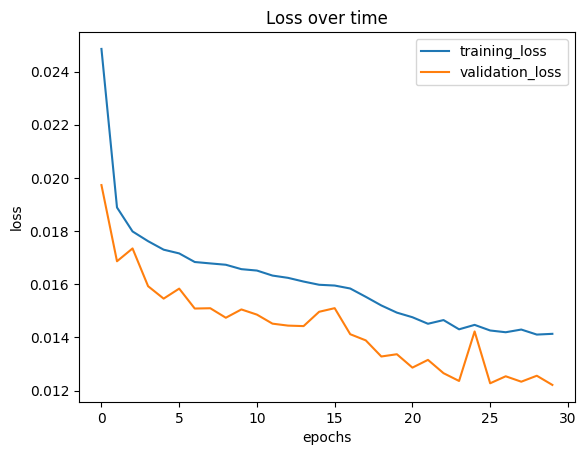

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.index, history['loss'], label='training_loss')
ax.plot(history.index, history['val_loss'], label='validation_loss')
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.set_title('Loss over time')
ax.legend()
plt.show()

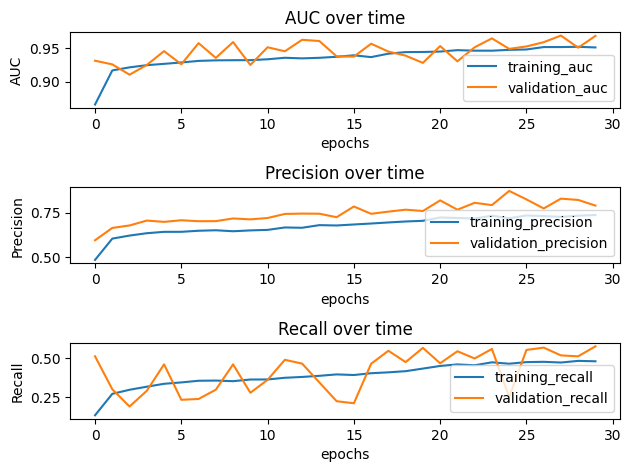

In [ ]:
fig, ax = plt.subplots(3,1)
ax[0].plot(history.index, history['auc'], label='training_auc')
ax[0].plot(history.index, history['val_auc'], label='validation_auc')
ax[0].set_ylabel('AUC')
ax[0].set_xlabel('epochs')
ax[0].set_title('AUC over time')
ax[0].legend()

ax[1].plot(history.index, history['precision'], label='training_precision')
ax[1].plot(history.index, history['val_precision'], label='validation_precision')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('epochs')
ax[1].set_title('Precision over time')
ax[1].legend()

ax[2].plot(history.index, history['recall'], label='training_recall')
ax[2].plot(history.index, history['val_recall'], label='validation_recall')
ax[2].set_ylabel('Recall')
ax[2].set_xlabel('epochs')
ax[2].set_title('Recall over time')
ax[2].legend()

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
loss, auc, precision, recall = nn.evaluate(X_test, y_test, verbose=0)
print('The test loss is: ' + str(loss))
print('The test AUC is: ' + str(auc))
print('The test precision is: ' + str(precision))
print('The test recall is: ' + str(recall))

The test loss is: 0.009909294545650482
The test AUC is: 0.9648966789245605
The test precision is: 0.6880841255187988
The test recall is: 0.5491841435432434


### **5.10.2.- Random Undersampling**

In [ ]:
# Create a pipeline with RandomUnderSampler and Neural Network
pipeline_over_nn = imb_make_pipeline(RandomUnderSampler(random_state=42),
                                     KerasClassifier(model=create_model, optimizer='adam'))

In [ ]:
hist = nn.fit(X_train, y_train, validation_data=(X_cal, y_cal), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
15196/15196 [==============================] - 103s 6ms/step - loss: 0.0276 - auc: 0.8585 - precision: 0.2539 - recall: 0.1311 - val_loss: 0.0183 - val_auc: 0.9086 - val_precision: 0.6191 - val_recall: 0.2104
Epoch 2/30
15196/15196 [==============================] - 88s 6ms/step - loss: 0.0191 - auc: 0.9118 - precision: 0.6095 - recall: 0.2684 - val_loss: 0.0169 - val_auc: 0.9297 - val_precision: 0.6761 - val_recall: 0.3447
Epoch 3/30
15196/15196 [==============================] - 89s 6ms/step - loss: 0.0180 - auc: 0.9255 - precision: 0.6347 - recall: 0.3114 - val_loss: 0.0160 - val_auc: 0.9478 - val_precision: 0.7003 - val_recall: 0.4433
Epoch 4/30
15196/15196 [==============================] - 87s 6ms/step - loss: 0.0174 - auc: 0.9309 - precision: 0.6366 - recall: 0.3224 - val_loss: 0.0158 - val_auc: 0.9295 - val_precision: 0.7199 - val_recall: 0.4108
Epoch 5/30
15196/15196 [==============================] - 89s 6ms/step - loss: 0.0171 - auc: 0.9300 - precision: 0.6405 - r

In [ ]:
history = pd.DataFrame(hist.history)
history = history.rename({history.columns[0]: "loss",
                          history.columns[1]: "auc",
                          history.columns[2]: "precision",
                          history.columns[3]: "recall",
                          history.columns[4]: "val_loss",
                          history.columns[5]: "val_auc",
                          history.columns[6]: "val_precision",
                          history.columns[7]: "val_recall"}, axis='columns')

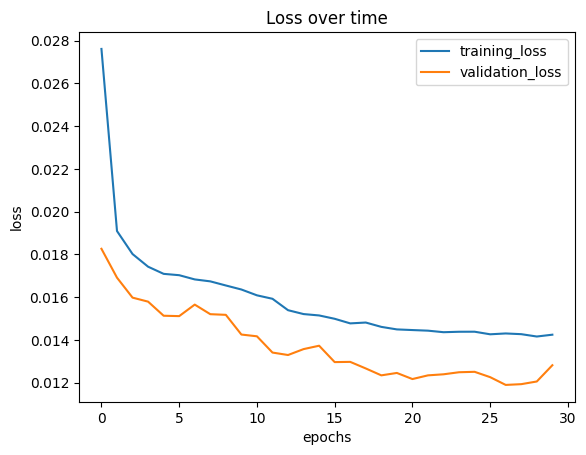

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.index, history['loss'], label='training_loss')
ax.plot(history.index, history['val_loss'], label='validation_loss')
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.set_title('Loss over time')
ax.legend()
plt.show()

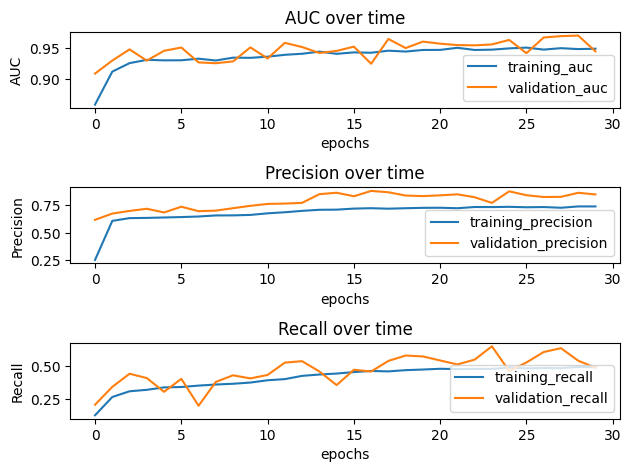

In [ ]:
fig, ax = plt.subplots(3,1)
ax[0].plot(history.index, history['auc'], label='training_auc')
ax[0].plot(history.index, history['val_auc'], label='validation_auc')
ax[0].set_ylabel('AUC')
ax[0].set_xlabel('epochs')
ax[0].set_title('AUC over time')
ax[0].legend()

ax[1].plot(history.index, history['precision'], label='training_precision')
ax[1].plot(history.index, history['val_precision'], label='validation_precision')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('epochs')
ax[1].set_title('Precision over time')
ax[1].legend()

ax[2].plot(history.index, history['recall'], label='training_recall')
ax[2].plot(history.index, history['val_recall'], label='validation_recall')
ax[2].set_ylabel('Recall')
ax[2].set_xlabel('epochs')
ax[2].set_title('Recall over time')
ax[2].legend()

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
loss, auc, precision, recall = nn.evaluate(X_test, y_test, verbose=0)
print('The test loss is: ' + str(loss))
print('The test AUC is: ' + str(auc))
print('The test precision is: ' + str(precision))
print('The test recall is: ' + str(recall))

The test loss is: 0.009738372638821602
The test AUC is: 0.9374113082885742
The test precision is: 0.7534142732620239
The test recall is: 0.46293705701828003


### **5.10.3- Balanced Weights**

In [ ]:
pos = sum(y_train)
neg = y_train.shape[0] - pos
class_weight = {0: 1, 1: neg/pos}

In [ ]:
hist = nn.fit(X_train, y_train,
              validation_data=(X_cal, y_cal),
              epochs=30,
              batch_size=64,
              class_weight=class_weight,
              verbose=1)

Epoch 1/30
15196/15196 [==============================] - 82s 5ms/step - loss: 0.3870 - auc: 0.9768 - precision: 0.0845 - recall: 0.9126 - val_loss: 0.1389 - val_auc: 0.9850 - val_precision: 0.0891 - val_recall: 0.9435
Epoch 2/30
15196/15196 [==============================] - 81s 5ms/step - loss: 0.3692 - auc: 0.9784 - precision: 0.0886 - recall: 0.9190 - val_loss: 0.1527 - val_auc: 0.9856 - val_precision: 0.0903 - val_recall: 0.9494
Epoch 3/30
15196/15196 [==============================] - 89s 6ms/step - loss: 0.3613 - auc: 0.9797 - precision: 0.0895 - recall: 0.9197 - val_loss: 0.1330 - val_auc: 0.9851 - val_precision: 0.1116 - val_recall: 0.9307
Epoch 4/30
15196/15196 [==============================] - 89s 6ms/step - loss: 0.3590 - auc: 0.9795 - precision: 0.0893 - recall: 0.9208 - val_loss: 0.1189 - val_auc: 0.9839 - val_precision: 0.1140 - val_recall: 0.9270
Epoch 5/30
15196/15196 [==============================] - 89s 6ms/step - loss: 0.3542 - auc: 0.9800 - precision: 0.0900 - re

In [ ]:
history = pd.DataFrame(hist.history)
history = history.rename({history.columns[0]: "loss",
                          history.columns[1]: "auc",
                          history.columns[2]: "precision",
                          history.columns[3]: "recall",
                          history.columns[4]: "val_loss",
                          history.columns[5]: "val_auc",
                          history.columns[6]: "val_precision",
                          history.columns[7]: "val_recall"}, axis='columns')

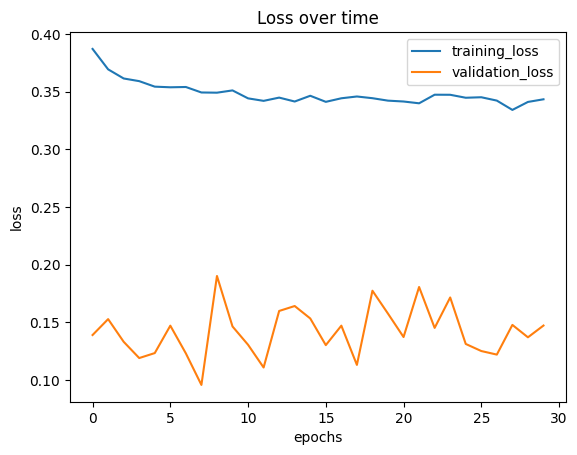

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.index, history['loss'], label='training_loss')
ax.plot(history.index, history['val_loss'], label='validation_loss')
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.set_title('Loss over time')
ax.legend()
plt.show()

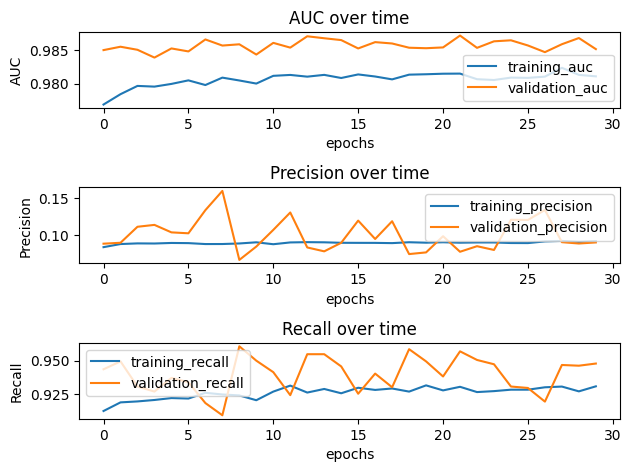

In [ ]:
fig, ax = plt.subplots(3,1)
ax[0].plot(history.index, history['auc'], label='training_auc')
ax[0].plot(history.index, history['val_auc'], label='validation_auc')
ax[0].set_ylabel('AUC')
ax[0].set_xlabel('epochs')
ax[0].set_title('AUC over time')
ax[0].legend()

ax[1].plot(history.index, history['precision'], label='training_precision')
ax[1].plot(history.index, history['val_precision'], label='validation_precision')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('epochs')
ax[1].set_title('Precision over time')
ax[1].legend()

ax[2].plot(history.index, history['recall'], label='training_recall')
ax[2].plot(history.index, history['val_recall'], label='validation_recall')
ax[2].set_ylabel('Recall')
ax[2].set_xlabel('epochs')
ax[2].set_title('Recall over time')
ax[2].legend()

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
loss, auc, precision, recall = nn.evaluate(X_test, y_test, verbose=0)
print('The test loss is: ' + str(loss))
print('The test AUC is: ' + str(auc))
print('The test precision is: ' + str(precision))
print('The test recall is: ' + str(recall))

The test loss is: 0.14598576724529266
The test AUC is: 0.9837720394134521
The test precision is: 0.06216499209403992
The test recall is: 0.9407925605773926


### **5.10.4- Neural Network Results**

| Sampling Method | Best Hyper-parameter         | Best Val. Score (Recall) |  AUC ROC | Precision |
|----------|----------|----------|----------|----------|
| Default Baseline | {} | 0.55 |  0.96 | 0.69|
| Random Undersampling |{} |0.46 |0.94| 0.75 |
| Balanced Weight |{} | 0.94 | 0.98 | 0.06 |

In [ ]:
data = {
    'Sampling Method': ['Default Baseline', 'Random Undersampling', 'Balanced Weight'],
    'Recall': [0.55, 0.46, 0.94],
    'AUC ROC': [0.96, 0.94, 0.98],
    'Precision': [0.69, 0.75, 0.06]
}

data = pd.DataFrame(data)
data["Model"] = 'Neural Network'
all_models = all_models.append(data)

In [ ]:
all_models = all_models.reset_index().drop(['index'], axis = 1)
all_models['F1'] = round(all_models['Recall']*all_models['Precision']*2/(all_models['Recall'] + all_models['Precision']),2)

sampling_method_labels = {
        "Default Baseline": "base",
        "Random Oversampling": "ros",
        "Random Undersampling": "rus",
        "SMOTE": "smote",
        "Balanced Weight": "balanced"
    }

model_labels = {
        "Decision Tree": "Dec.Tree",
        "KNN": "KNN",
        "Logistic Regression": "Log.Reg",
        "SVM": "SVM",
        "Random Forest": "R.Forest",
        "Light GBM": "GBM",
        "XGBoost": "XGBoost",
        "Adaboost": "Adaboost",
        "HistGradient Boosting":"Hist.Gradient",
        "Neural Network":"NN"
    }

all_models['Sampling'] = all_models['Sampling Method'].map(sampling_method_labels)
all_models['ModelName'] = all_models['Model'].map(model_labels)


all_models['Model-ID'] = all_models['ModelName']+"-"+all_models["Sampling"]

# **6.- Final Model Selection**


## 6.1.- AUC ROC

All models we have trained have achieved a High AUC ROC (higher than 87%). This is remarkable for the following reasons:
- It signals effective discrimination between positive and negative classes, assigning a higher probability of being 1, to instances of 1. These values will help deploy the model and have accurate predictions.
- High AUC ROC scores are particularly valuable in scenarios with imbalanced datasets, where traditional accuracy metrics might be misleading. The AUC ROC is less sensitive to class imbalance, providing a more trustworthy measure of model performance.
- A high AUC ROC often translates to a better generalization capability, meaning the model is likely to perform well on unseen data.





In [ ]:
display(all_models)

,Sampling Method,Recall,AUC ROC,Precision,Model,F1,Sampling,ModelName,Model-ID
0,Default Baseline,0.68,0.97,0.78,Decision Tree,0.73,base,Dec.Tree,Dec.Tree-base
1,Random Oversampling,0.95,0.97,0.11,Decision Tree,0.20,ros,Dec.Tree,Dec.Tree-ros
2,Random Undersampling,0.96,0.98,0.07,Decision Tree,0.13,rus,Dec.Tree,Dec.Tree-rus
3,SMOTE,0.95,0.98,0.15,Decision Tree,0.26,smote,Dec.Tree,Dec.Tree-smote
4,Balanced Weight,0.95,0.98,0.12,Decision Tree,0.21,balanced,Dec.Tree,Dec.Tree-balanced
5,Default Baseline,0.53,0.87,0.82,KNN,0.64,base,KNN,KNN-base
6,Random Oversampling,0.85,0.94,0.15,KNN,0.26,ros,KNN,KNN-ros
7,Random Undersampling,0.93,0.97,0.05,KNN,0.09,rus,KNN,KNN-rus
8,SMOTE,0.93,0.97,0.05,KNN,0.09,smote,KNN,KNN-smote
9,Default Baseline,0.01,0.89,0.11,Logistic Regression,0.02,base,Log.Reg,Log.Reg-base


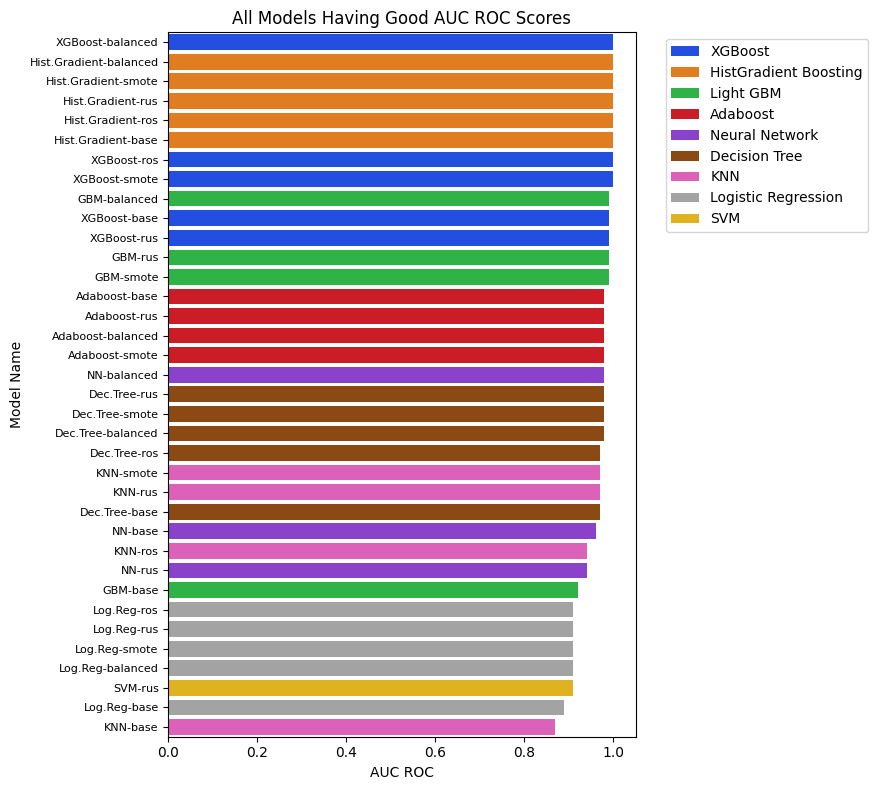

In [ ]:
sorted_models = all_models.sort_values('AUC ROC', ascending=False)
#Create the horizontal bar plot
plt.figure(figsize=(9, 8))
sns.barplot(x='AUC ROC', y='Model-ID', hue='Model', data=sorted_models, palette="bright", dodge=False)
plt.xlabel('AUC ROC')
plt.ylabel('Model Name')
plt.title('All Models Having Good AUC ROC Scores')
plt.yticks(fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 6.2.- Recall vs Precision


In fraud detection a high recall in a model is the most important metric because it ensures that the maximum number of fraudulent transactions are identified. On the other hand, having a good precision metric is also desirable. **However**, increasing recall comes at the cost of a lower precision score. Lower precision implies that while more fraudulent transactions are detected, the number of false positives increase. This **trade-off** can be detrimental to a business in several ways: (i) it can lead to operational delays and expenses in verifying false positives, (ii) it can cause inconvenience and frustration for customers whose legitimate transactions are erroneously declined or delayed, damaging customer relationship. **Therefore**, achieving a balance between high recall and acceptable precision is essential for effective and efficient fraud detection.

In the **context** of fraud detection models, an acceptable level of precision can vary significantly depending on the specific needs and circumstances of the company that is going to deploy the model. Also industry standards and regulation can play an important rol when selection a precision metric.

##6.3.- Best Model Selection

In the context of Recall vs Precision trade-off, and depending on the company needs, we propose two techniques to select best models:

### 6.3.1) Choose models with high recall, at expense of precision.
For this we would focus on models that have a recall of at least 85.0% and precision higher than 15.0%:

In [ ]:
filtered_models = all_models.loc[(all_models['Precision'] > 0.145) & (all_models['Recall'] >= 0.845)].reset_index().drop(['index'], axis = 1)
display(filtered_models)

,Sampling Method,Recall,AUC ROC,Precision,Model,F1,Sampling,ModelName,Model-ID
0,SMOTE,0.95,0.98,0.15,Decision Tree,0.26,smote,Dec.Tree,Dec.Tree-smote
1,Random Oversampling,0.85,0.94,0.15,KNN,0.26,ros,KNN,KNN-ros
2,SMOTE,0.95,0.99,0.15,Light GBM,0.26,smote,GBM,GBM-smote
3,Balanced Weight,0.96,0.99,0.22,Light GBM,0.36,balanced,GBM,GBM-balanced
4,SMOTE,0.95,1.00,0.15,XGBoost,0.26,smote,XGBoost,XGBoost-smote
5,Balanced Weight,0.94,1.00,0.18,XGBoost,0.30,balanced,XGBoost,XGBoost-balanced
6,Random Oversampling,0.96,1.00,0.17,HistGradient Boosting,0.29,ros,Hist.Gradient,Hist.Gradient-ros
7,SMOTE,0.95,1.00,0.18,HistGradient Boosting,0.30,smote,Hist.Gradient,Hist.Gradient-smote


We will plot our filtered models in a scatter plot, and see precision vs recall for each of them:

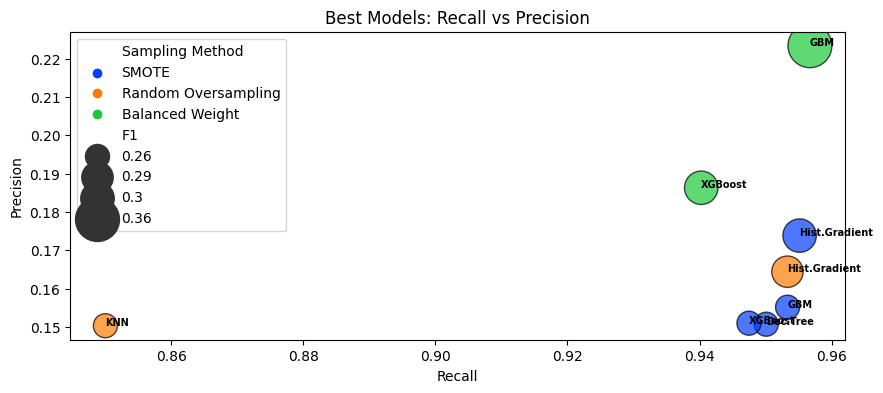

In [ ]:
plt.figure(figsize=(10, 4))

jitter_amount = 0.007
filtered_models["Recall_jittered"] = filtered_models["Recall"] + np.random.uniform(-jitter_amount, jitter_amount, len(filtered_models))
filtered_models["Precision_jittered"] = filtered_models["Precision"] + np.random.uniform(-jitter_amount, jitter_amount, len(filtered_models))

# Creating a scatter plot
sns.scatterplot(data=filtered_models, x="Recall_jittered", y="Precision_jittered", hue="Sampling Method", palette = sns.color_palette("bright"),
                edgecolor="black", linewidth=1, alpha=0.7, sizes=(300, 1000), size="F1")
# Adding labels
for i in range(filtered_models.shape[0]):
    plt.text(filtered_models.Recall_jittered[i], filtered_models.Precision_jittered[i], filtered_models['ModelName'][i],
             horizontalalignment='left', size=7, color='black', weight='semibold')

plt.title("Best Models: Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='upper left')
plt.show()


We can highlight the following results:
- 8 models were selected based on the criteria imposed.
- 50% of these models are related to the Smote technique, collaborating with Hist Gradient Boosting, Decision Tree, XGboost, and GBM. This shows that this technique is quite effective if we need to increase the recall of our model.
- Balanced weight and oversampling participate each with 25% of models.
- Notice that the highest value achieved for F1 is just 0.36: as said before, this type of selection is choosing the best models in terms of recall.



**Under this methodology, the best model would be Light GBM with Balanced Weight**

### 6.3.2) Choose the top 25% models with highest F1 model.

This criteria would take into consideration both, recall and precision, as this metric takes the harmonic average between the two.

In [ ]:
filtered_models = all_models[all_models["F1"] >= all_models["F1"].quantile(0.75)].reset_index(drop=True)
display(filtered_models)

,Sampling Method,Recall,AUC ROC,Precision,Model,F1,Sampling,ModelName,Model-ID
0,Default Baseline,0.68,0.97,0.78,Decision Tree,0.73,base,Dec.Tree,Dec.Tree-base
1,Default Baseline,0.53,0.87,0.82,KNN,0.64,base,KNN,KNN-base
2,Default Baseline,0.60,0.92,0.44,Light GBM,0.51,base,GBM,GBM-base
3,Default Baseline,0.56,0.99,0.75,XGBoost,0.64,base,XGBoost,XGBoost-base
4,Default Baseline,0.53,0.98,0.71,Adaboost,0.61,base,Adaboost,Adaboost-base
5,Balanced Weight,0.53,0.98,0.71,Adaboost,0.61,balanced,Adaboost,Adaboost-balanced
6,Default Baseline,0.65,1.00,0.75,HistGradient Boosting,0.70,base,Hist.Gradient,Hist.Gradient-base
7,Default Baseline,0.55,0.96,0.69,Neural Network,0.61,base,NN,NN-base
8,Random Undersampling,0.46,0.94,0.75,Neural Network,0.57,rus,NN,NN-rus


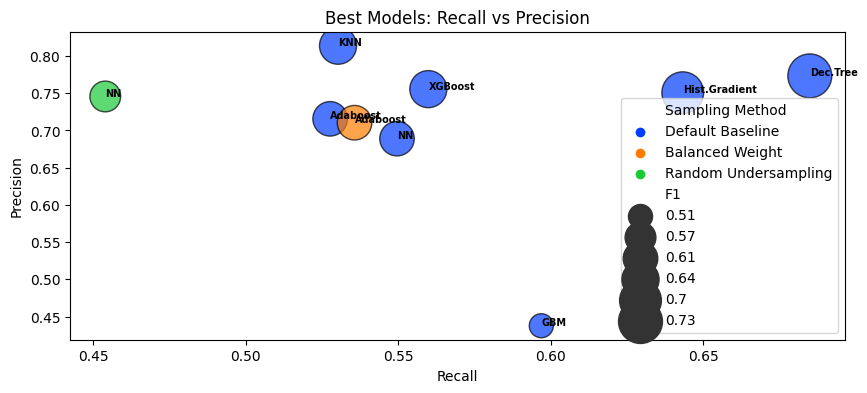

In [ ]:
plt.figure(figsize=(10, 4))

jitter_amount = 0.007
filtered_models["Recall_jittered"] = filtered_models["Recall"] + np.random.uniform(-jitter_amount, jitter_amount, len(filtered_models))
filtered_models["Precision_jittered"] = filtered_models["Precision"] + np.random.uniform(-jitter_amount, jitter_amount, len(filtered_models))

# Creating a scatter plot
sns.scatterplot(data=filtered_models, x="Recall_jittered", y="Precision_jittered", hue="Sampling Method", palette = sns.color_palette("bright"),
                edgecolor="black", linewidth=1, alpha=0.7, sizes=(300, 1000), size="F1")
# Adding labels
for i in range(filtered_models.shape[0]):
    plt.text(filtered_models.Recall_jittered[i], filtered_models.Precision_jittered[i], filtered_models['ModelName'][i],
             horizontalalignment='left', size=7, color='black', weight='semibold')

plt.title("Best Models: Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower right',bbox_to_anchor=(1, 0.5))
plt.show()



We can highlight the following results:
- Notice that our F1 score is much higher, but at the same time recall range now is lower. The trade off between precision and recall is quite visible.
- Also notice that the majority of the models are Baseline models after doing hyperparameter tunning: optimizing for recall comes at the expense of precision.
- It is a business decision how much to pay for each extra unit of recall.


**Under this methodology, the best model would be the Baseline Decision Tree**

### 6.3.3) Choosing model for Calibration

As we explained before, subject to business constraints, we can choose between focusing on both recall and precision, or just recall. Depending on the decision criteria, our two best models are:

| Modelling Techniques | Best Sampling Method | Best Val. Score (Recall) |  AUC ROC | Precision | F1 |Choosing Criteria |
|----------|----------|----------|----------|----------|----------|----------|
| Decision Tree | Default Baseline |  0.68 |  1.00 | 0.78 | 0.73 | Max F1|
| Light GBM |Balanced Weight | 0.96 | 0.99 | 0.22 | 0.36 |Max Recall|


Finally, we will choose Light GBM as the best final model with the metric of recall and calibrate it.  In the case of fraud detection, it is desired to decrease False Negatives as much as possible, since the cost of labeling fraudulent transactions as non-fraudulent is high, so we will focus on recall to assess the performance of the model.

# **7.- Model Calibration**

- Calibration is a crucial concept in the context of transaction fraud detection models. In this context, calibration refers to the accuracy of a model's predicted probabilities in reflecting the actual likelihood of a transaction being fraudulent. Ensuring that a fraud detection model is well-calibrated is essential for several reasons:
  - Precision in Risk Assessment: In fraud detection, having well-calibrated predicted probabilities means that when the model assigns a probability to a transaction, it accurately represents the likelihood of it being fraudulent. This precision is vital for assessing the risk associated with each transaction.
  - Threshold Selection: Setting an appropriate threshold is a pivotal decision in fraud detection. A well-calibrated model provides a solid foundation for choosing the threshold that strikes the right balance between detecting fraud and minimizing false alarms. This helps optimize the decision-making process.
  - Compliance and Regulatory Standards: Financial institutions are often subject to strict regulations that require robust risk assessment in their transaction processes. Well-calibrated models not only enhance decision-making accuracy but also align with regulatory compliance, which is essential for maintaining the integrity of fraud detection systems.
  - Effective Model Evaluation: When evaluating the performance of a transaction fraud detection model, it's not just about accuracy or broader metrics; it's also about assessing how closely the model's predicted probabilities match actual outcomes. A well-calibrated model excels in this aspect, providing a more comprehensive evaluation.
- In transaction fraud detection, achieving calibration is accomplished through techniques like Platt scaling or isotonic regression. These techniques adjust the model's raw scores or probabilities, ensuring that they are consistent with the true likelihood of a transaction being fraudulent.
- To sum up, calibration is a fundamental component of transaction fraud detection models, ensuring that the model's predictions are not only accurate but also trustworthy indicators of the likelihood of fraud. This reliability is instrumental in making informed decisions, complying with regulations, and optimizing the trade-off between detecting fraudulent transactions and minimizing false alarms.


## 7.1 Platt Saling VS Isotonic Regression

In [ ]:
best_recall_model = LGBMClassifier(class_weight='balanced', random_state=42, n_estimators = 50, max_depth = 10)
best_recall_model.fit(X_train, y_train)

calibrated_sigmoid = CalibratedClassifierCV(best_recall_model, method='sigmoid', cv=5)
calibrated_isotonic = CalibratedClassifierCV(best_recall_model, method='isotonic', cv=5)

calibrated_sigmoid.fit(X_cal, y_cal)
calibrated_isotonic.fit(X_cal, y_cal)

y_pred_calibrate_sigmoid = calibrated_sigmoid.predict(X_cal)
y_pred_calibrate_isotonic = calibrated_isotonic.predict(X_cal)

validation_recall_calibrate_sigmoid = recall_score(y_cal, y_pred_calibrate_sigmoid)
validation_recall_calibrate_isotonic = recall_score(y_cal, y_pred_calibrate_isotonic)

print(f"validation_recall_score (Calibrate - Sigmoid): {validation_recall_calibrate_sigmoid}")
print(f"validation_recall_score (Calibrate - Isotonic): {validation_recall_calibrate_isotonic}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5629, number of negative: 966877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 972506, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you did

## 7.2 Final Calibration Model Selection
- Since Isotonic has a higher validation recall score, we will use Isotonic method to calibrate the model.

In [ ]:
best_recall_calibrated_isotonic_model = CalibratedClassifierCV(best_recall_model, method='isotonic', cv='prefit')
best_recall_calibrated_isotonic_model.fit(X_cal, y_cal)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(class_weight='balanced',
                                                max_depth=10, n_estimators=50,
                                                random_state=42),
                       method='isotonic')

# **8.- Feature Importances/Model Explanation (SHAP)**

We will use SHAP (SHapley Additive exPlanations) summary plot to show the feature importance. SHAP summary plots provide a global view of the feature importances in a machine learning model by using Shapley values from game theory to attribute the contribution of each feature to the prediction.

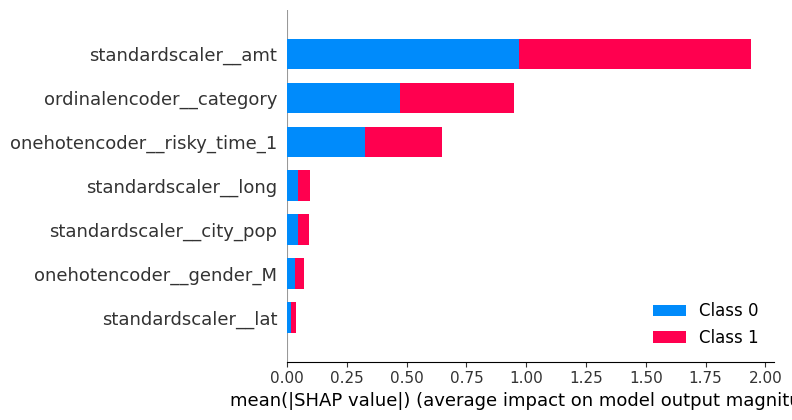

In [ ]:
explainer = shap.TreeExplainer(best_recall_model, model_output='raw')
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.summary_plot(shap_values, X_test, feature_names = feature_names_)

The x-axis represents the mean absolute Shapley value for a feature across all data points. This value quantifies the impact of a feature on the model's output. A higher absolute value on this axis means that the feature has a larger impact on the model's output.

For the Light GBM model, the three most impartant features are still **standardscaler_amt**, **ordinalencoder_category**, and **ordinalencoder_risky_time_1**. It aligns with the practical understanding and our expectations that the type of product and the transaction amount play significant roles in determining the likelihood of credit card fraud.

We can also see that the feature **ordinalencoder_risky_time_1** is the third most important feature. This is a good sign and underscores the effectiveness of our feature engineering efforts. This confirms that extracting transection hours from **trans_date_trans_time** and encoding it to risky time as 1 and 0 can successfully capture relevant patterns for the model's fraud detection capabilities.

We can see that red and blue regions are evenly distributed across a feature, it implies that these features have a relatively balanced impact on both classes 0 and 1.

# **9.- Model Evaluation Over Test Data Set**

## 9.1 Light GBM Best In Terms of Recall

In [ ]:
y_pred_test = best_recall_calibrated_isotonic_model.predict(X_test)

recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
auc_roc_test = roc_auc_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Recall (Test): {recall_test}")
print(f"Precision (Test): {precision_test}")
print(f"AUC-ROC (Test): {auc_roc_test}")
print(f"F1-Score (Test): {f1_test}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Recall (Test): 0.717016317016317
Precision (Test): 0.6927927927927928
AUC-ROC (Test): 0.8578921613695645
F1-Score (Test): 0.7046964490263459


If we choose recall as our prediction metric, the best model we choose is Light GBM. The test recall score is reported as approximately 0.717, indicating that the model is able to correctly identify around 71.7% of the positive cases (true positives) out of all actual positive cases (true positives plus false negatives).


# **10.- Business Use Cases**

We used a flow chart to describe the process for handling customer transactions and utilizing a machine learning model to detect and prevent credit card fraud. This flow chart outlines the decision-making process that could be automated within a credit card transaction system.

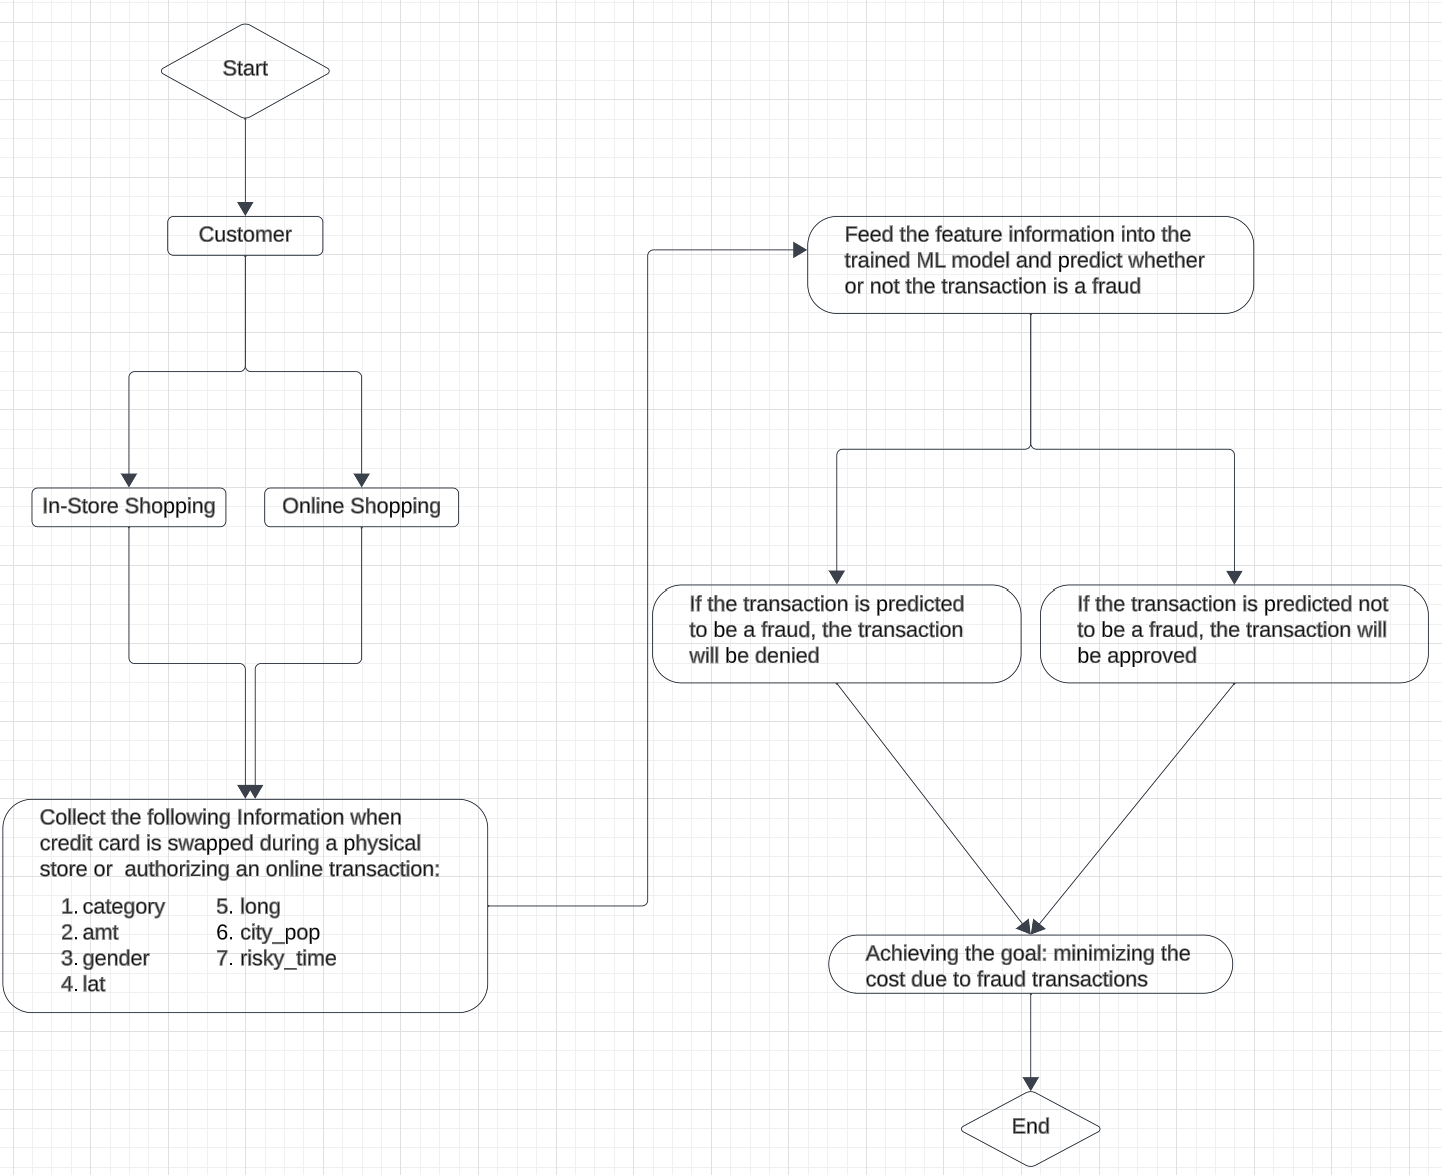

In [ ]:
image_path = "/content/drive/My Drive/AML Project/AML Project Business Use Case.png"
Image(filename=image_path)

**1. Start**:
The process begins when a customer initiates a transaction.

**2. Customer**:
This step represents the customer engaging in the transaction.

**3. Shopping Channel**
The customer has two options for conducting the transaction:
- In-Store Shopping
- Online Shopping

**4. Information Collection**
During the transaction, the following features wll be collected:
- `category`: The type of product or service purchased.
- `amt`: The amount of money involved in the transaction.
- `gender`: The gender of the customer (if available).
- `lat`: Latitude coordinate where the transaction occurs (for in-store).
- `long`: Longitude coordinate where the transaction occurs.
- `city_pop`: Population of the city where the transaction occurs.
- `risky_time`: An encoded feature indicating the risk associated with the time of the transaction.

**5. Fraud Detection**
The collected feature information is fed into a trained machine learning (ML) model to predict whether the transaction is likely fraudulent.

**6. Decision Making**
- If the **ML model predicts fraud**, the transaction will be **denied** to prevent potential fraud.
- If the **ML model predicts no fraud**, the transaction will be **approved**, allowing the transaction to proceed.

**7. Goal**
The overarching goal of this process is to **minimize the cost associated with fraudulent transactions**.

**8. End**
The process concludes after the transaction has been either approved or denied.
